In [1]:
!pip install pyyaml==5.4.1
!pip install darts
import darts
print(darts.__version__)
!pip install -U optuna==2.0.0
!pip install matplotlib == 3.1.1

import numpy as np
import pandas as pd
import time
from tqdm import tqdm
import sklearn
from sklearn import preprocessing
import torch
import matplotlib.pyplot as plt
import gc
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

from darts import TimeSeries
from darts.utils.timeseries_generation import gaussian_timeseries, linear_timeseries, sine_timeseries
from darts.models import LightGBMModel, CatBoostModel, Prophet, RNNModel, TFTModel, NaiveSeasonal, ExponentialSmoothing, NHiTSModel
from darts.metrics import mape, smape, rmse, rmsle
from darts.dataprocessing import Pipeline
from darts.dataprocessing.transformers import Scaler, StaticCovariatesTransformer, MissingValuesFiller, InvertibleMapper
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.statistics import check_seasonality, plot_acf, plot_residuals_analysis, plot_hist
from darts.utils.likelihood_models import QuantileRegression
from darts.utils.missing_values import fill_missing_values
from darts.models import MovingAverage

import optuna
from optuna.integration import PyTorchLightningPruningCallback
from optuna.visualization import (
    plot_optimization_history,
    plot_contour,
    plot_param_importances,
)

%matplotlib inline
torch.manual_seed(1); np.random.seed(1)  # for reproducibility

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
0.22.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Invalid requirement: '=='


1. Preprocess data

This part loads all .csv files to create corresponding TimeSeries(Darts), static_covariates, past_covariates and future_covariates. 

1.1 Load Data

In [2]:
from google.colab import drive
drive.mount("/content/drive")

# Load all Datasets
df_train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/store-sales-time-series-forecasting/train.csv')
df_test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/store-sales-time-series-forecasting/test.csv')
df_holidays_events = pd.read_csv('/content/drive/My Drive/Colab Notebooks/store-sales-time-series-forecasting/holidays_events.csv')
df_oil = pd.read_csv('/content/drive/My Drive/Colab Notebooks/store-sales-time-series-forecasting/oil.csv')
df_stores = pd.read_csv('/content/drive/My Drive/Colab Notebooks/store-sales-time-series-forecasting/stores.csv')
df_transactions = pd.read_csv('/content/drive/My Drive/Colab Notebooks/store-sales-time-series-forecasting/transactions.csv')
df_sample_submission = pd.read_csv('/content/drive/My Drive/Colab Notebooks/store-sales-time-series-forecasting/sample_submission.csv')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


1.2 Process Train and Test DataFrame for later use

In [3]:

# Merge train.csv with store.csv for future use

family_list = df_train['family'].unique()
store_list = df_stores['store_nbr'].unique()

train_merged = pd.merge(df_train, df_stores, on ='store_nbr')
train_merged = train_merged.sort_values(["store_nbr","family","date"])
train_merged = train_merged.astype({"store_nbr":'str', "family":'str', "city":'str',
                          "state":'str', "type":'str', "cluster":'str'})

# drop 'onpromotion' column of test.csv and sort it by 'store_nbr' and 'family' for prediction use

df_test_dropped = df_test.drop(['onpromotion'], axis=1)
df_test_sorted = df_test_dropped.sort_values(by=['store_nbr','family'])

train_merged.head(5)
# df_test_sorted.head(5)

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13
33,1782,2013-01-02,1,AUTOMOTIVE,2.0,0,Quito,Pichincha,D,13
66,3564,2013-01-03,1,AUTOMOTIVE,3.0,0,Quito,Pichincha,D,13
99,5346,2013-01-04,1,AUTOMOTIVE,3.0,0,Quito,Pichincha,D,13
132,7128,2013-01-05,1,AUTOMOTIVE,5.0,0,Quito,Pichincha,D,13


1.3 Create TimeSeries for each Store Groupby each Family

In [4]:

# Create TimeSeries using Darts and arrange in a dict <k,v> = <family,TimeSeries for each store>, total 33 x 54 = 1782

family_TS_dict = {}

for family in family_list:
  df_family = train_merged.loc[train_merged['family'] == family]

  list_of_TS_family = TimeSeries.from_group_dataframe(
                                df_family,
                                time_col="date",
                                group_cols=["store_nbr","family"],  # individual time series are extracted by grouping `df` by `group_cols`
                                static_cols=["city","state","type","cluster"], # also extract these additional columns as static covariates
                                value_cols="sales", # target variable
                                fill_missing_dates=True,
                                freq='D')
  for ts in list_of_TS_family:
            ts = ts.astype(np.float32)

  list_of_TS_family = sorted(list_of_TS_family, key=lambda ts: int(ts.static_covariates_values()[0,0]))
  family_TS_dict[family] = list_of_TS_family

# Transform the Sales Data

family_pipeline_dict = {}
family_TS_transformed_dict = {}

for key in family_TS_dict:
  train_filler = MissingValuesFiller(verbose=False, n_jobs=-1, name="Fill NAs")
  static_cov_transformer = StaticCovariatesTransformer(verbose=False, transformer_cat = sklearn.preprocessing.OneHotEncoder(), name="Encoder") #OneHotEncoder would be better but takes longer
  log_transformer = InvertibleMapper(np.log1p, np.expm1, verbose=False, n_jobs=-1, name="Log-Transform")   
  train_scaler = Scaler(verbose=False, n_jobs=-1, name="Scaling")

  train_pipeline = Pipeline([train_filler,
                             static_cov_transformer,
                             log_transformer,
                             train_scaler])
     
  training_transformed = train_pipeline.fit_transform(family_TS_dict[key])
  family_pipeline_dict[key] = train_pipeline
  family_TS_transformed_dict[key] = training_transformed

# family_TS_transformed_dict['AUTOMOTIVE'][0].static_covariates.iloc[0,54:]
family_TS_transformed_dict['AUTOMOTIVE'][0]


<TimeSeries (DataArray) (date: 1688, component: 1, sample: 1)>
array([[[0.        ]],

       [[0.36672579]],

       [[0.46275643]],

       ...,

       [[0.23137821]],

       [[0.23137821]],

       [[0.53724357]]])
Coordinates:
  * date       (date) datetime64[ns] 2013-01-01 2013-01-02 ... 2017-08-15
  * component  (component) object 'sales'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  static_covariates  store_nbr_1  store_nbr_10  store_n...
    hierarchy:          None

1.4 Create Moving Average Features of Sales

In [5]:

# Create 7-day and 28-day moving average of sales

sales_moving_average_7 = MovingAverage(window=7)
sales_moving_average_28 = MovingAverage(window=28)

sales_moving_averages_dict = {}

for key in family_TS_transformed_dict:
  sales_mas_family = []
  
  for ts in family_TS_transformed_dict[key]:
    ma_7 = sales_moving_average_7.filter(ts)
    ma_7 = TimeSeries.from_series(ma_7.pd_series())  
    ma_7 = ma_7.astype(np.float32)
    ma_7 = ma_7.with_columns_renamed(col_names=ma_7.components, col_names_new="sales_ma_7")
    ma_28 = sales_moving_average_28.filter(ts)
    ma_28 = TimeSeries.from_series(ma_28.pd_series())  
    ma_28 = ma_28.astype(np.float32)
    ma_28 = ma_28.with_columns_renamed(col_names=ma_28.components, col_names_new="sales_ma_28")
    mas = ma_7.stack(ma_28)
    sales_mas_family.append(mas)
  
  sales_moving_averages_dict[key] = sales_mas_family  

sales_moving_averages_dict["AUTOMOTIVE"][0]

<TimeSeries (DataArray) (date: 1688, component: 2, sample: 1)>
array([[[0.32305965],
        [0.3514414 ]],

       [[0.37806854],
        [0.3434372 ]],

       [[0.3761781 ],
        [0.3364335 ]],

       ...,

       [[0.44159347],
        [0.53641903]],

       [[0.3761878 ],
        [0.5554841 ]],

       [[0.4123902 ],
        [0.5436196 ]]], dtype=float32)
Coordinates:
  * date       (date) datetime64[ns] 2013-01-01 2013-01-02 ... 2017-08-15
  * component  (component) object 'sales_ma_7' 'sales_ma_28'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

1.5 Create General Time Features

In [6]:
   
# General Covariates (Time-Based and Oil Price)

full_time_period = pd.date_range(start='2013-01-01', end='2017-08-31', freq='D')

# Time-Based Covariates

year = datetime_attribute_timeseries(time_index = full_time_period, attribute="year")
month = datetime_attribute_timeseries(time_index = full_time_period, attribute="month")
day = datetime_attribute_timeseries(time_index = full_time_period, attribute="day")
dayofyear = datetime_attribute_timeseries(time_index = full_time_period, attribute="dayofyear")
weekday = datetime_attribute_timeseries(time_index = full_time_period, attribute="dayofweek")
weekofyear = datetime_attribute_timeseries(time_index = full_time_period, attribute="weekofyear")
timesteps = TimeSeries.from_times_and_values(times=full_time_period,
                                             values=np.arange(len(full_time_period)),
                                             columns=["linear_increase"])

time_cov = year.stack(month).stack(day).stack(dayofyear).stack(weekday).stack(weekofyear).stack(timesteps)
time_cov = time_cov.astype(np.float32)

# Transform
time_cov_scaler = Scaler(verbose=False, n_jobs=-1, name="Scaler")
time_cov_train, time_cov_val = time_cov.split_before(pd.Timestamp('20170816'))
time_cov_scaler.fit(time_cov_train) # ? only scale train data
time_cov_transformed = time_cov_scaler.transform(time_cov)

# time_cov_transformed[-50:].plot()
time_cov_transformed

<TimeSeries (DataArray) (time: 1704, component: 7, sample: 1)>
array([[[0.0000000e+00],
        [0.0000000e+00],
        [0.0000000e+00],
        ...,
        [1.6666667e-01],
        [0.0000000e+00],
        [0.0000000e+00]],

       [[0.0000000e+00],
        [0.0000000e+00],
        [3.3333335e-02],
        ...,
        [3.3333334e-01],
        [0.0000000e+00],
        [5.9276825e-04]],

       [[0.0000000e+00],
        [0.0000000e+00],
        [6.6666678e-02],
        ...,
...
        ...,
        [1.6666667e-01],
        [6.5384614e-01],
        [1.0082988e+00]],

       [[1.0000000e+00],
        [6.3636363e-01],
        [9.6666664e-01],
        ...,
        [3.3333334e-01],
        [6.5384614e-01],
        [1.0088916e+00]],

       [[1.0000000e+00],
        [6.3636363e-01],
        [1.0000001e+00],
        ...,
        [5.0000000e-01],
        [6.5384614e-01],
        [1.0094843e+00]]], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 2013-01-01 2013-01-02 ... 2017-08-31
  * component  (component) object 'year' 'month' ... 'linear_increase'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

1.6 Create Oil Price Features

In [7]:

# Oil Price

oil = TimeSeries.from_dataframe(df_oil, 
                                time_col = 'date', 
                                value_cols = ['dcoilwtico'],
                                freq = 'D')

oil = oil.astype(np.float32)

# Transform
oil_filler = MissingValuesFiller(verbose=False, n_jobs=-1, name="Filler")
oil_scaler = Scaler(verbose=False, n_jobs=-1, name="Scaler")
oil_pipeline = Pipeline([oil_filler, oil_scaler])
oil_transformed = oil_pipeline.fit_transform(oil)

# Moving Averages for Oil Price
oil_moving_average_7 = MovingAverage(window=7)
oil_moving_average_28 = MovingAverage(window=28)

oil_moving_averages = []

ma_7 = oil_moving_average_7.filter(oil_transformed).astype(np.float32)
ma_7 = ma_7.with_columns_renamed(col_names=ma_7.components, col_names_new="oil_ma_7")
ma_28 = oil_moving_average_28.filter(oil_transformed).astype(np.float32)
ma_28 = ma_28.with_columns_renamed(col_names=ma_28.components, col_names_new="oil_ma_28")
oil_moving_averages = ma_7.stack(ma_28)

# Stack General Covariates Together

general_covariates = time_cov_transformed.stack(oil_transformed).stack(oil_moving_averages)

general_covariates

<TimeSeries (DataArray) (time: 1704, component: 10, sample: 1)>
array([[[0.        ],
        [0.        ],
        [0.        ],
        ...,
        [0.7929646 ],
        [0.79240197],
        [0.796154  ]],

       [[0.        ],
        [0.        ],
        [0.03333334],
        ...,
        [0.7929646 ],
        [0.7925303 ],
        [0.7960361 ]],

       [[0.        ],
        [0.        ],
        [0.06666668],
        ...,
...
        ...,
        [0.2400805 ],
        [0.24278495],
        [0.25032222]],

       [[1.        ],
        [0.6363636 ],
        [0.96666664],
        ...,
        [0.23415849],
        [0.24149394],
        [0.25014064]],

       [[1.        ],
        [0.6363636 ],
        [1.0000001 ],
        ...,
        [0.2495558 ],
        [0.24079117],
        [0.25054285]]], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 2013-01-01 2013-01-02 ... 2017-08-31
  * component  (component) object 'year' 'month' ... 'oil_ma_7' 'oil_ma_28'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

1.7 Create Transaction Feature

In [8]:
# Store-Specific Covariates (Transactions and Holidays)

# Transactions
df_transactions.sort_values(["store_nbr","date"], inplace=True)

TS_transactions_list = TimeSeries.from_group_dataframe(
                                df_transactions,
                                time_col="date",
                                group_cols=["store_nbr"],  # individual time series are extracted by grouping `df` by `group_cols`
                                value_cols="transactions",
                                fill_missing_dates=True,
                                freq='D')

transactions_list = []

for ts in TS_transactions_list:
            series = TimeSeries.from_series(ts.pd_series())   # necessary workaround to remove static covariates (so I can stack covariates later on)
            series = series.astype(np.float32)
            transactions_list.append(series)

transactions_list[24] = transactions_list[24].slice(start_ts=pd.Timestamp('20130102'), end_ts=pd.Timestamp('20170815'))

from datetime import datetime, timedelta

transactions_list_full = []

for ts in transactions_list:
  if ts.start_time() > pd.Timestamp('20130101'):
    # end_time = (ts.start_time() - timedelta(days=1))
    # delta = end_time - pd.Timestamp('20130101')
    delta = ts.start_time() - pd.Timestamp('20130101')
    zero_series = TimeSeries.from_times_and_values(
                              times=pd.date_range(start=pd.Timestamp('20130101'),
                              # end=end_time, freq="D"),
                              end=ts.start_time() - timedelta(days=1), freq="D"),
                              # values=np.zeros(delta.days+1))
                              values=np.zeros(delta.days))
    ts = zero_series.append(ts)
    transactions_list_full.append(ts)
  # transactions_list_full.append(ts)

transactions_filler = MissingValuesFiller(verbose=False, n_jobs=-1, name="Filler")
transactions_scaler = Scaler(verbose=False, n_jobs=-1, name="Scaler")

transactions_pipeline = Pipeline([transactions_filler, transactions_scaler])
transactions_transformed = transactions_pipeline.fit_transform(transactions_list_full)

# Moving Averages for Transactions
trans_moving_average_7 = MovingAverage(window=7)
trans_moving_average_28 = MovingAverage(window=28)

transactions_covs = []

for ts in transactions_transformed:
  ma_7 = trans_moving_average_7.filter(ts).astype(np.float32)
  ma_7 = ma_7.with_columns_renamed(col_names=ma_7.components, col_names_new="transactions_ma_7")
  ma_28 = trans_moving_average_28.filter(ts).astype(np.float32)
  ma_28 = ma_28.with_columns_renamed(col_names=ma_28.components, col_names_new="transactions_ma_28")
  trans_and_mas = ts.with_columns_renamed(col_names=ts.components, col_names_new="transactions").stack(ma_7).stack(ma_28)
  transactions_covs.append(trans_and_mas)

# transactions_list_full[24]
transactions_covs[0]

<TimeSeries (DataArray) (time: 1688, component: 3, sample: 1)>
array([[[0.        ],
        [0.48023486],
        [0.48931998]],

       [[0.69831293],
        [0.4840225 ],
        [0.49374792]],

       [[0.60635131],
        [0.43202117],
        [0.50285316]],

       ...,

       [[0.13761164],
        [0.395854  ],
        [0.46284369]],

       [[0.57327158],
        [0.35831955],
        [0.48104119]],

       [[0.5600397 ],
        [0.40076083],
        [0.47182709]]])
Coordinates:
  * time       (time) datetime64[ns] 2013-01-01 2013-01-02 ... 2017-08-15
  * component  (component) object 'transactions' ... 'transactions_ma_28'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

1.8 Create Holiday Feature

In [9]:


# Re-Defining Categories of Holidays

df_holidays_events['type'] = np.where(df_holidays_events['transferred'] == True,'Transferred', 
                                      df_holidays_events['type'])

df_holidays_events['type'] = np.where(df_holidays_events['type'] == 'Transfer','Holiday', 
                                      df_holidays_events['type'])

df_holidays_events['type'] = np.where(df_holidays_events['type'] == 'Additional','Holiday', 
                                      df_holidays_events['type'])

df_holidays_events['type'] = np.where(df_holidays_events['type'] == 'Bridge','Holiday', 
                                      df_holidays_events['type'])

holiday_df_per_store = []

for i in range(0,len(df_stores)):
  df_holiday_event_mask = pd.DataFrame(columns=['date'])
  df_holiday_event_mask["date"] = df_holidays_events["date"]

  df_holiday_event_mask["national_holiday"] = np.where(((df_holidays_events["type"] == "Holiday") & 
                                                      (df_holidays_events["locale"] == "National")), 1, 0)
  df_holiday_event_mask["earthquake_relief"] = np.where(df_holidays_events['description'].str.contains('Terremoto Manabi'), 1, 0)
  df_holiday_event_mask["christmas"] = np.where(df_holidays_events['description'].str.contains('Navidad'), 1, 0)
  df_holiday_event_mask["football_event"] = np.where(df_holidays_events['description'].str.contains('futbol'), 1, 0)
  df_holiday_event_mask["national_event"] = np.where(((df_holidays_events["type"] == "Event") & 
                                                    (df_holidays_events["locale"] == "National") & 
                                                    (~df_holidays_events['description'].str.contains('Terremoto Manabi')) & 
                                                    (~df_holidays_events['description'].str.contains('futbol'))), 1, 0)
  # no local event in dataset
  df_holiday_event_mask["work_day"] = np.where((df_holidays_events["type"] == "Work Day"), 1, 0)
  # df_holiday_event_mask["regional_holiday"] = np.where((df_holidays_events["type"] == "Holiday") & 
  #                                                 (df_holidays_events["locale_name"] == df_stores['state'][i]), 1, 0)
  # df_holiday_event_mask["local_holiday"] = np.where((df_holidays_events["type"] == "Holiday") &
  #                                                   (df_holidays_events["locale_name"] == df_stores['city'][i]), 1, 0)
  df_holiday_event_mask["local_holiday"] = np.where(((df_holidays_events["type"] == "Holiday") & 
                                                    ((df_holidays_events["locale_name"] == df_stores['state'][i]) | 
                                                    (df_holidays_events["locale_name"] == df_stores['city'][i]))), 1, 0)
            
  holiday_df_per_store.append(df_holiday_event_mask)


# remove all zeros mask and duplicates dates in holiday_list

holiday_df_filter_per_store = []

for i in range(0,len(holiday_df_per_store)):     
  df_holiday = holiday_df_per_store[i].set_index('date')
  df_holiday = df_holiday.loc[~((df_holiday==0).all(axis=1))]
  df_holiday = df_holiday.groupby('date').agg({'national_holiday':'max', 'earthquake_relief':'max', 
                          # 'christmas':'max', 'football_event':'max', 'regional_holiday': 'max', 'work_day':'max',
                          'christmas':'max', 'football_event':'max', 'work_day':'max',
                          'national_event':'max', 'local_holiday':'max'}).reset_index()
  holiday_df_filter_per_store.append(df_holiday)

holiday_list_store = []

# workday and wage paid day timeseries

# df_wage = pd.DataFrame(index=pd.date_range(start=pd.Timestamp('20130101'),end=pd.Timestamp('20170831'),freq='D')
# ,columns=['workday','wage'])
# df_wage['workday'] = np.where(df_wage.index.dayofweek < 5, 1, 0)
# df_wage['wage'] = np.where((df_wage.index.day == 15) | (df_wage.index.is_month_end), 1, 0)
# wage_TS = TimeSeries.from_dataframe(df_wage)
# cols = ['national_holiday','regional_holiday','local_holiday']
# cols = ['national_holiday','local_holiday']


for i in range(0,len(df_stores)): 
  holidays_TS = TimeSeries.from_dataframe(holiday_df_filter_per_store[i], 
                              time_col = 'date',
                              fill_missing_dates=True,
                              fillna_value=0,
                              freq='D')
  holidays_TS = holidays_TS.slice(pd.Timestamp('20130101'),pd.Timestamp('20170831'))

  # add workday and wages paid day
  
  # holidays_TS = holidays_TS.stack(wage_TS)
  # holidays_df = holidays_TS.pd_dataframe()
  # holidays_df['workday'] = np.where((holidays_df[['work_day','workday']].max(1) == 1) & 
  #                                 (holidays_df[cols].max(1) == 0), 1, 0)
  # holidays_df.drop('work_day',axis=1, inplace=True)

  # merge holidays to a single column 
  
  # holidays_df['holiday'] = np.where(holidays_df[cols].max(1) == 1, 1, 0)
  # holidays_df.drop(cols,axis=1,inplace=True)

  # change back to TS

  # holidays_TS = TimeSeries.from_dataframe(holidays_df)

  holidays_TS = holidays_TS.astype(np.float32)
  holiday_list_store.append(holidays_TS)

holidays_filler = MissingValuesFiller(verbose=False, n_jobs=-1, name="Filler")
holidays_scaler = Scaler(verbose=False, n_jobs=-1, name="Scaler")

holidays_pipeline = Pipeline([holidays_filler, holidays_scaler])
holidays_transformed = holidays_pipeline.fit_transform(holiday_list_store)

holidays_transformed[24].pd_dataframe()[1400:1425]

component,national_holiday,earthquake_relief,christmas,football_event,work_day,national_event,local_holiday
date,,,,,,,
2016-11-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-11-02,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-11-03,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-11-04,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-11-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-11-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-11-07,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2016-11-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-11-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0


1.9 Create onpromotion Feature

In [10]:

# Store/Family-Specific Covariates (Promotion)

df_promotion = pd.concat([df_train, df_test], axis=0)
df_promotion = df_promotion.sort_values(["store_nbr","family","date"])
# df_promotion.tail()

family_promotion_dict = {}

for family in family_list:
  df_family = df_promotion.loc[df_promotion['family'] == family]

  list_of_TS_promo = TimeSeries.from_group_dataframe(
                                df_family,
                                time_col="date",
                                group_cols=["store_nbr","family"],  # individual time series are extracted by grouping `df` by `group_cols`
                                value_cols="onpromotion", # covariate of interest
                                fill_missing_dates=True,
                                freq='D')
  
  for ts in list_of_TS_promo:
            ts = ts.astype(np.float32)

  family_promotion_dict[family] = list_of_TS_promo

promotion_transformed_dict = {}

for key in family_promotion_dict:
  promo_filler = MissingValuesFiller(verbose=False, n_jobs=-1, name="Fill NAs")
  promo_scaler = Scaler(verbose=False, n_jobs=-1, name="Scaling")

  promo_pipeline = Pipeline([promo_filler,
                             promo_scaler])
  
  promotion_transformed = promo_pipeline.fit_transform(family_promotion_dict[key])

  # Moving Averages for Promotion Family Dictionaries
  promo_moving_average_7 = MovingAverage(window=7)
  promo_moving_average_28 = MovingAverage(window=28)

  promotion_covs = []

  for ts in promotion_transformed:
    ma_7 = promo_moving_average_7.filter(ts)
    ma_7 = TimeSeries.from_series(ma_7.pd_series())  
    ma_7 = ma_7.astype(np.float32)
    ma_7 = ma_7.with_columns_renamed(col_names=ma_7.components, col_names_new="promotion_ma_7")
    ma_28 = promo_moving_average_28.filter(ts)
    ma_28 = TimeSeries.from_series(ma_28.pd_series())  
    ma_28 = ma_28.astype(np.float32)
    ma_28 = ma_28.with_columns_renamed(col_names=ma_28.components, col_names_new="promotion_ma_28")
    promo_and_mas = ts.stack(ma_7).stack(ma_28)
    promotion_covs.append(promo_and_mas)

  promotion_transformed_dict[key] = promotion_covs
  
# promotion_transformed_dict['AUTOMOTIVE'][0].pd_dataframe()
promotion_transformed_dict['GROCERY I'][52].pd_dataframe()


component,onpromotion,promotion_ma_7,promotion_ma_28
date,,,
2013-01-01,0.000000,0.000000,0.000000
2013-01-02,0.000000,0.000000,0.000000
2013-01-03,0.000000,0.000000,0.000000
2013-01-04,0.000000,0.000000,0.000000
2013-01-05,0.000000,0.000000,0.000000
...,...,...,...
2017-08-27,0.058030,0.065356,0.054691
2017-08-28,0.064777,0.070368,0.055331
2017-08-29,0.064777,0.071525,0.056283


1.10 Assemble all Covariates

In [11]:

# Stack Together Store-Specific Covariates with General Covariates

# future covariates: general_covariates, holidays and promotion
# past covariates: moving avereage sales, transaction, general_covariates, holidays and promotion
# only past covariates: moving average sales, transaction

store_covariates_future = []

for store in range(0,len(store_list)):
  stacked_covariates = holidays_transformed[store].stack(general_covariates)  
  store_covariates_future.append(stacked_covariates)

store_covariates_past = []
holidays_transformed_sliced = holidays_transformed # for slicing past covariates

for store in range(0,len(store_list)):
  holidays_transformed_sliced[store] = holidays_transformed[store].slice_intersect(transactions_covs[store])
  general_covariates_sliced = general_covariates.slice_intersect(transactions_covs[store])
  stacked_covariates = transactions_covs[store].stack(holidays_transformed_sliced[store]).stack(general_covariates_sliced)  
  store_covariates_past.append(stacked_covariates)
    

# Assemble All Covariates in Dictionaries

past_covariates_dict = {}

for key in tqdm(promotion_transformed_dict):

  promotion_family = promotion_transformed_dict[key]
  sales_mas = sales_moving_averages_dict[key]
  covariates_past = [promotion_family[i].slice_intersect(store_covariates_past[i]).stack(store_covariates_past[i].stack(sales_mas[i])) \
                    for i in range(0,len(promotion_family))]

  past_covariates_dict[key] = covariates_past

future_covariates_dict = {}

for key in tqdm(promotion_transformed_dict):

  promotion_family = promotion_transformed_dict[key]
  covariates_future = [promotion_family[i].stack(store_covariates_future[i]) for i in range(0,len(promotion_family))]

  future_covariates_dict[key] = covariates_future

only_past_covariates_dict = {}

for key in tqdm(sales_moving_averages_dict):
  sales_moving_averages = sales_moving_averages_dict[key]
  only_past_covariates = [sales_moving_averages[i].stack(transactions_covs[i]) for i in range(0,len(sales_moving_averages))]

  only_past_covariates_dict[key] = only_past_covariates


# Delete Original Dataframes to Save Memory

del(df_train)
del(df_test)
del(df_stores)
del(df_holidays_events)
del(df_oil)
del(df_transactions)
gc.collect()

# past_covariates_dict['AUTOMOTIVE'][0].pd_dataframe()
# future_covariates_dict['AUTOMOTIVE'][0].pd_dataframe()
only_past_covariates_dict['AUTOMOTIVE'][0].pd_dataframe()

100%|██████████| 33/33 [00:05<00:00,  6.60it/s]


component,sales_ma_7,sales_ma_28,transactions,transactions_ma_7,transactions_ma_28
date,,,,,
2013-01-01,0.323060,0.351441,0.000000,0.480235,0.489320
2013-01-02,0.378069,0.343437,0.698313,0.484022,0.493748
2013-01-03,0.376178,0.336434,0.606351,0.432021,0.502853
2013-01-04,0.322438,0.330254,0.616275,0.455697,0.508027
2013-01-05,0.374828,0.311906,0.499173,0.544020,0.511872
...,...,...,...,...,...
2017-08-11,0.477671,0.544763,0.188554,0.426209,0.468078
2017-08-12,0.477671,0.536465,0.332120,0.422759,0.460121
2017-08-13,0.441593,0.536419,0.137612,0.395854,0.462844


2. Tune Global LightGDM Model

Tune the LightGBM mode for each family. The last 16 days of the train data are chosen for the validaition set. Utilize Optuna to help us tune the hyperparameters. Manual tuning is also included, which tests a small set of each hyperparameter and their plots are showed as well. For simplicity, all LightGBM would share hyperparameters in manual tuning. 

2.1 Tuning by Optuna

Using Optuna package to help us find best parameters for each family in all 33 models.
 
(Don't skip this part if you want models generated by Optuna)

In [20]:

# Train 33 Global LightGBM Models (one for each product family) by Optuna

import warnings
warnings.filterwarnings(action='ignore')

# Use Optuna to help tune LightGBM 

LGBM_rmsle = {}
LGBM_dict = {}

def flatten(l):
  return [item for item in l]

def build_lightgdm(lags,
                   lags_future_covariates,
                   lags_past_covariates,
                   FUTURE_covariates,
                   PAST_covariates,
                   train_sliced):
  
  LGBM_Model = LightGBMModel(lags=lags,
                             lags_future_covariates=lags_future_covariates,
                             lags_past_covariates=lags_past_covariates,
                             output_chunk_length=1,
                             random_state=2022,
                             gpu_use_dp= "false")
  
  LGBM_Model.fit(series=train_sliced, 
                 future_covariates=FUTURE_covariates,
                 past_covariates=PAST_covariates,
                 verbose=True)
  
  return LGBM_Model

def objective(trial, family):
  # add trial parameters and expand trial set to search more parameter space
  lags = trial.suggest_categorical("lags", [35, 63, 91])
  lags_future_covariates = trial.suggest_categorical("lags_future_covariates", [(7,1), (14, 1)])
  lags_past_covariates = trial.suggest_categorical("lags_past_covariates", [[i for i in range(-16, -23, -1)],
                                                                            [i for i in range(-16, -30, -1)]])
  # random_state = trial.suggest_categorical("random_states", [100, 1000])

  err_val = 0
  num_test = 0

  for i in range(-16, -15, 16): # set backtest range and stride
    sales_family = family_TS_transformed_dict[family]
    train_sliced = [ts[:i] for ts in sales_family]
    TCN_covariates = future_covariates_dict[family]
    # PAST_covariates = past_covariates_dict[family]
    PAST_covariates = transactions_transformed
    # PAST_covariates = only_past_covariates_dict[family]


    model = build_lightgdm(lags=lags,
                          lags_future_covariates=lags_future_covariates,
                          lags_past_covariates=lags_past_covariates,
                          FUTURE_covariates=TCN_covariates,
                          PAST_covariates=PAST_covariates,
                          train_sliced=train_sliced
                          )

    forecast_LGBM = model.predict(n=16,
                                  series=train_sliced,
                                  future_covariates=TCN_covariates,
                                  past_covariates=PAST_covariates)

    LGBM_Forecasts_Families = forecast_LGBM
    LGBM_Forecasts_Families_back = family_pipeline_dict[family].inverse_transform(LGBM_Forecasts_Families, partial=True)

    for n in range(0,len(LGBM_Forecasts_Families_back)):
      if (train_sliced[n].univariate_values()[-14:] == 0).all():
        LGBM_Forecasts_Families_back[n] = LGBM_Forecasts_Families_back[n].map(lambda x: x * 0)
    
    # Evaluate performance for each family of forecasts
    actual_list = flatten(family_TS_dict[family])
    # pred_list_LGBM = flatten(LGBM_Forecasts_Families_back[family])
    # actual_list = flatten([ts[i:i + 16] for ts in sales_family] if i + 16 != 0 else [ts[i:] for ts in sales_family])
    pred_list_LGBM = flatten(LGBM_Forecasts_Families_back)
    # Return score 
    err = rmsle(actual_series = actual_list,
                  pred_series = pred_list_LGBM,
                  n_jobs = -1,
                  inter_reduction=np.mean)
    
    err_val += err
    num_test += 1

  return err_val / num_test

def print_callback(study, trial):
  print(f"Current value: {trial.value}, Current params: {trial.params}")


# Actual training

for family in tqdm(family_list):
  study_lightgbm = optuna.create_study(direction="minimize")
  study_lightgbm.optimize(lambda trial: objective(trial, family), n_trials=5, callbacks=[print_callback]) # add trials to get better performance
  # Best parameters for each family
  print(f"Best value: {study_lightgbm.best_value}, Best params: {study_lightgbm.best_trial.params}")
  params = study_lightgbm.best_trial.params
  LGBM_rmsle[family] = study_lightgbm.best_value
  LGBM_dict[family] = LightGBMModel(lags=params["lags"],
                                    lags_future_covariates=params["lags_future_covariates"],
                                    lags_past_covariates=params["lags_past_covariates"],
                                    output_chunk_length=1,
                                    random_state=2022,
                                    gpu_use_dp= "false")




  0%|          | 0/33 [00:00<?, ?it/s][I 2022-12-14 20:56:15,370] Trial 0 finished with value: 0.4963974470082558 and parameters: {'lags': 35, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}. Best is trial 0 with value: 0.4963974470082558.


Current value: 0.4963974470082558, Current params: {'lags': 35, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}


[I 2022-12-14 20:56:40,863] Trial 1 finished with value: 0.49061546369540626 and parameters: {'lags': 91, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}. Best is trial 1 with value: 0.49061546369540626.


Current value: 0.49061546369540626, Current params: {'lags': 91, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}


[I 2022-12-14 20:57:06,662] Trial 2 finished with value: 0.49308273099806993 and parameters: {'lags': 91, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}. Best is trial 1 with value: 0.49061546369540626.


Current value: 0.49308273099806993, Current params: {'lags': 91, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}


[I 2022-12-14 20:57:38,359] Trial 3 finished with value: 0.4944776888129098 and parameters: {'lags': 63, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}. Best is trial 1 with value: 0.49061546369540626.


Current value: 0.4944776888129098, Current params: {'lags': 63, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}


[I 2022-12-14 20:58:04,272] Trial 4 finished with value: 0.49308273099806993 and parameters: {'lags': 91, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}. Best is trial 1 with value: 0.49061546369540626.
  3%|▎         | 1/33 [02:20<1:14:52, 140.39s/it]

Current value: 0.49308273099806993, Current params: {'lags': 91, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}
Best value: 0.49061546369540626, Best params: {'lags': 91, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}


[I 2022-12-14 20:58:17,109] Trial 0 finished with value: 0.2011360511379895 and parameters: {'lags': 35, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}. Best is trial 0 with value: 0.2011360511379895.


Current value: 0.2011360511379895, Current params: {'lags': 35, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}


[I 2022-12-14 20:58:35,192] Trial 1 finished with value: 0.20431108480737295 and parameters: {'lags': 63, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}. Best is trial 0 with value: 0.2011360511379895.


Current value: 0.20431108480737295, Current params: {'lags': 63, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}


[I 2022-12-14 20:58:53,851] Trial 2 finished with value: 0.2029919902376861 and parameters: {'lags': 63, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}. Best is trial 0 with value: 0.2011360511379895.


Current value: 0.2029919902376861, Current params: {'lags': 63, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}


[I 2022-12-14 20:59:10,854] Trial 3 finished with value: 0.20126520890921012 and parameters: {'lags': 35, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}. Best is trial 0 with value: 0.2011360511379895.


Current value: 0.20126520890921012, Current params: {'lags': 35, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}


[I 2022-12-14 20:59:23,453] Trial 4 finished with value: 0.20213913681165263 and parameters: {'lags': 35, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}. Best is trial 0 with value: 0.2011360511379895.
  6%|▌         | 2/33 [03:39<53:55, 104.38s/it]  

Current value: 0.20213913681165263, Current params: {'lags': 35, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}
Best value: 0.2011360511379895, Best params: {'lags': 35, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}


[I 2022-12-14 20:59:47,655] Trial 0 finished with value: 0.45975686134343213 and parameters: {'lags': 63, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}. Best is trial 0 with value: 0.45975686134343213.


Current value: 0.45975686134343213, Current params: {'lags': 63, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}


[I 2022-12-14 21:00:33,005] Trial 1 finished with value: 0.4565443501020557 and parameters: {'lags': 91, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}. Best is trial 1 with value: 0.4565443501020557.


Current value: 0.4565443501020557, Current params: {'lags': 91, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}


[I 2022-12-14 21:00:51,679] Trial 2 finished with value: 0.45783576981877827 and parameters: {'lags': 35, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}. Best is trial 1 with value: 0.4565443501020557.


Current value: 0.45783576981877827, Current params: {'lags': 35, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}


[I 2022-12-14 21:01:20,019] Trial 3 finished with value: 0.4582366758189668 and parameters: {'lags': 35, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}. Best is trial 1 with value: 0.4565443501020557.


Current value: 0.4582366758189668, Current params: {'lags': 35, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}


[I 2022-12-14 21:01:50,926] Trial 4 finished with value: 0.4635453539780895 and parameters: {'lags': 63, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}. Best is trial 1 with value: 0.4565443501020557.
  9%|▉         | 3/33 [06:07<1:02:01, 124.06s/it]

Current value: 0.4635453539780895, Current params: {'lags': 63, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}
Best value: 0.4565443501020557, Best params: {'lags': 91, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}


[I 2022-12-14 21:02:13,370] Trial 0 finished with value: 0.21629331267246563 and parameters: {'lags': 63, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}. Best is trial 0 with value: 0.21629331267246563.


Current value: 0.21629331267246563, Current params: {'lags': 63, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}


[I 2022-12-14 21:02:41,348] Trial 1 finished with value: 0.21613279509423272 and parameters: {'lags': 35, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}. Best is trial 1 with value: 0.21613279509423272.


Current value: 0.21613279509423272, Current params: {'lags': 35, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}


[I 2022-12-14 21:03:04,688] Trial 2 finished with value: 0.22040001928330766 and parameters: {'lags': 63, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}. Best is trial 1 with value: 0.21613279509423272.


Current value: 0.22040001928330766, Current params: {'lags': 63, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}


[I 2022-12-14 21:03:33,519] Trial 3 finished with value: 0.22130356645195481 and parameters: {'lags': 91, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}. Best is trial 1 with value: 0.21613279509423272.


Current value: 0.22130356645195481, Current params: {'lags': 91, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}


[I 2022-12-14 21:04:07,212] Trial 4 finished with value: 0.22376641213157425 and parameters: {'lags': 91, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}. Best is trial 1 with value: 0.21613279509423272.
 12%|█▏        | 4/33 [08:23<1:02:17, 128.89s/it]

Current value: 0.22376641213157425, Current params: {'lags': 91, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}
Best value: 0.21613279509423272, Best params: {'lags': 35, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}


[I 2022-12-14 21:04:21,438] Trial 0 finished with value: 0.052555130747453965 and parameters: {'lags': 91, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}. Best is trial 0 with value: 0.052555130747453965.


Current value: 0.052555130747453965, Current params: {'lags': 91, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}


[I 2022-12-14 21:04:36,847] Trial 1 finished with value: 0.05246688667843288 and parameters: {'lags': 91, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}. Best is trial 1 with value: 0.05246688667843288.


Current value: 0.05246688667843288, Current params: {'lags': 91, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}


[I 2022-12-14 21:04:53,752] Trial 2 finished with value: 0.04948019394514727 and parameters: {'lags': 63, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}. Best is trial 2 with value: 0.04948019394514727.


Current value: 0.04948019394514727, Current params: {'lags': 63, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}


[I 2022-12-14 21:05:11,505] Trial 3 finished with value: 0.0531260468567316 and parameters: {'lags': 91, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}. Best is trial 2 with value: 0.04948019394514727.


Current value: 0.0531260468567316, Current params: {'lags': 91, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}


[I 2022-12-14 21:05:22,193] Trial 4 finished with value: 0.04979920994039367 and parameters: {'lags': 35, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}. Best is trial 2 with value: 0.04948019394514727.
 15%|█▌        | 5/33 [09:38<51:04, 109.45s/it]  

Current value: 0.04979920994039367, Current params: {'lags': 35, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}
Best value: 0.04948019394514727, Best params: {'lags': 63, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}


[I 2022-12-14 21:05:57,302] Trial 0 finished with value: 0.16962393573642312 and parameters: {'lags': 91, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}. Best is trial 0 with value: 0.16962393573642312.


Current value: 0.16962393573642312, Current params: {'lags': 91, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}


[I 2022-12-14 21:06:29,782] Trial 1 finished with value: 0.16955079931721773 and parameters: {'lags': 63, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}. Best is trial 1 with value: 0.16955079931721773.


Current value: 0.16955079931721773, Current params: {'lags': 63, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}


[I 2022-12-14 21:06:57,131] Trial 2 finished with value: 0.16530739682104578 and parameters: {'lags': 35, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}. Best is trial 2 with value: 0.16530739682104578.


Current value: 0.16530739682104578, Current params: {'lags': 35, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}


[I 2022-12-14 21:07:27,023] Trial 3 finished with value: 0.16955079931721773 and parameters: {'lags': 63, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}. Best is trial 2 with value: 0.16530739682104578.


Current value: 0.16955079931721773, Current params: {'lags': 63, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}


[I 2022-12-14 21:08:00,297] Trial 4 finished with value: 0.1657583586779562 and parameters: {'lags': 91, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}. Best is trial 2 with value: 0.16530739682104578.
 18%|█▊        | 6/33 [12:16<56:41, 125.99s/it]

Current value: 0.1657583586779562, Current params: {'lags': 91, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}
Best value: 0.16530739682104578, Best params: {'lags': 35, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}


[I 2022-12-14 21:08:24,195] Trial 0 finished with value: 0.5273571303451947 and parameters: {'lags': 91, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}. Best is trial 0 with value: 0.5273571303451947.


Current value: 0.5273571303451947, Current params: {'lags': 91, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}


[I 2022-12-14 21:08:49,981] Trial 1 finished with value: 0.5269970189520388 and parameters: {'lags': 91, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}. Best is trial 1 with value: 0.5269970189520388.


Current value: 0.5269970189520388, Current params: {'lags': 91, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}


[I 2022-12-14 21:09:15,915] Trial 2 finished with value: 0.5273571303451947 and parameters: {'lags': 91, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}. Best is trial 1 with value: 0.5269970189520388.


Current value: 0.5273571303451947, Current params: {'lags': 91, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}


[I 2022-12-14 21:09:36,424] Trial 3 finished with value: 0.5288463848401607 and parameters: {'lags': 63, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}. Best is trial 1 with value: 0.5269970189520388.


Current value: 0.5288463848401607, Current params: {'lags': 63, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}


[I 2022-12-14 21:09:56,936] Trial 4 finished with value: 0.5288463848401607 and parameters: {'lags': 63, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}. Best is trial 1 with value: 0.5269970189520388.
 21%|██        | 7/33 [14:13<53:16, 122.93s/it]

Current value: 0.5288463848401607, Current params: {'lags': 63, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}
Best value: 0.5269970189520388, Best params: {'lags': 91, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}


[I 2022-12-14 21:10:23,324] Trial 0 finished with value: 0.2825107727889589 and parameters: {'lags': 91, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}. Best is trial 0 with value: 0.2825107727889589.


Current value: 0.2825107727889589, Current params: {'lags': 91, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}


[I 2022-12-14 21:10:56,401] Trial 1 finished with value: 0.30304648924314914 and parameters: {'lags': 91, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}. Best is trial 0 with value: 0.2825107727889589.


Current value: 0.30304648924314914, Current params: {'lags': 91, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}


[I 2022-12-14 21:11:14,564] Trial 2 finished with value: 0.28713027017718007 and parameters: {'lags': 35, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}. Best is trial 0 with value: 0.2825107727889589.


Current value: 0.28713027017718007, Current params: {'lags': 35, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}


[I 2022-12-14 21:11:44,673] Trial 3 finished with value: 0.30246189840844795 and parameters: {'lags': 63, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}. Best is trial 0 with value: 0.2825107727889589.


Current value: 0.30246189840844795, Current params: {'lags': 63, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}


[I 2022-12-14 21:12:16,690] Trial 4 finished with value: 0.30246189840844795 and parameters: {'lags': 63, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}. Best is trial 0 with value: 0.2825107727889589.
 24%|██▍       | 8/33 [16:32<53:27, 128.29s/it]

Current value: 0.30246189840844795, Current params: {'lags': 63, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}
Best value: 0.2825107727889589, Best params: {'lags': 91, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}


[I 2022-12-14 21:12:44,153] Trial 0 finished with value: 0.14051594196125988 and parameters: {'lags': 91, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}. Best is trial 0 with value: 0.14051594196125988.


Current value: 0.14051594196125988, Current params: {'lags': 91, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}


[I 2022-12-14 21:13:10,786] Trial 1 finished with value: 0.14051594196125988 and parameters: {'lags': 91, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}. Best is trial 0 with value: 0.14051594196125988.


Current value: 0.14051594196125988, Current params: {'lags': 91, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}


[I 2022-12-14 21:13:30,445] Trial 2 finished with value: 0.1391679104544956 and parameters: {'lags': 35, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}. Best is trial 2 with value: 0.1391679104544956.


Current value: 0.1391679104544956, Current params: {'lags': 35, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}


[I 2022-12-14 21:13:52,843] Trial 3 finished with value: 0.1403716070130593 and parameters: {'lags': 63, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}. Best is trial 2 with value: 0.1391679104544956.


Current value: 0.1403716070130593, Current params: {'lags': 63, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}


[I 2022-12-14 21:14:15,087] Trial 4 finished with value: 0.1403716070130593 and parameters: {'lags': 63, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}. Best is trial 2 with value: 0.1391679104544956.
 27%|██▋       | 9/33 [18:31<50:04, 125.20s/it]

Current value: 0.1403716070130593, Current params: {'lags': 63, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}
Best value: 0.1391679104544956, Best params: {'lags': 35, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}


[I 2022-12-14 21:14:46,781] Trial 0 finished with value: 0.1801947390209564 and parameters: {'lags': 63, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}. Best is trial 0 with value: 0.1801947390209564.


Current value: 0.1801947390209564, Current params: {'lags': 63, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}


[I 2022-12-14 21:15:07,789] Trial 1 finished with value: 0.17924517226716702 and parameters: {'lags': 35, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}. Best is trial 1 with value: 0.17924517226716702.


Current value: 0.17924517226716702, Current params: {'lags': 35, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}


[I 2022-12-14 21:15:34,902] Trial 2 finished with value: 0.17598296978998554 and parameters: {'lags': 35, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}. Best is trial 2 with value: 0.17598296978998554.


Current value: 0.17598296978998554, Current params: {'lags': 35, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}


[I 2022-12-14 21:15:54,674] Trial 3 finished with value: 0.17912355147199038 and parameters: {'lags': 35, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}. Best is trial 2 with value: 0.17598296978998554.


Current value: 0.17912355147199038, Current params: {'lags': 35, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}


[I 2022-12-14 21:16:16,914] Trial 4 finished with value: 0.17919140525289037 and parameters: {'lags': 63, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}. Best is trial 2 with value: 0.17598296978998554.
 30%|███       | 10/33 [20:33<47:35, 124.16s/it]

Current value: 0.17919140525289037, Current params: {'lags': 63, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}
Best value: 0.17598296978998554, Best params: {'lags': 35, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}


[I 2022-12-14 21:16:39,244] Trial 0 finished with value: 0.25889550040784826 and parameters: {'lags': 63, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}. Best is trial 0 with value: 0.25889550040784826.


Current value: 0.25889550040784826, Current params: {'lags': 63, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}


[I 2022-12-14 21:17:05,005] Trial 1 finished with value: 0.25475879628192377 and parameters: {'lags': 35, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}. Best is trial 1 with value: 0.25475879628192377.


Current value: 0.25475879628192377, Current params: {'lags': 35, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}


[I 2022-12-14 21:17:22,952] Trial 2 finished with value: 0.25321099402121744 and parameters: {'lags': 35, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}. Best is trial 2 with value: 0.25321099402121744.


Current value: 0.25321099402121744, Current params: {'lags': 35, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}


[I 2022-12-14 21:17:42,693] Trial 3 finished with value: 0.25321099402121744 and parameters: {'lags': 35, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}. Best is trial 2 with value: 0.25321099402121744.


Current value: 0.25321099402121744, Current params: {'lags': 35, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}


[I 2022-12-14 21:18:16,866] Trial 4 finished with value: 0.25507556759075994 and parameters: {'lags': 91, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}. Best is trial 2 with value: 0.25321099402121744.
 33%|███▎      | 11/33 [22:32<45:03, 122.87s/it]

Current value: 0.25507556759075994, Current params: {'lags': 91, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}
Best value: 0.25321099402121744, Best params: {'lags': 35, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}


[I 2022-12-14 21:18:39,345] Trial 0 finished with value: 0.2642712554717414 and parameters: {'lags': 63, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}. Best is trial 0 with value: 0.2642712554717414.


Current value: 0.2642712554717414, Current params: {'lags': 63, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}


[I 2022-12-14 21:18:58,700] Trial 1 finished with value: 0.26006327823305675 and parameters: {'lags': 35, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}. Best is trial 1 with value: 0.26006327823305675.


Current value: 0.26006327823305675, Current params: {'lags': 35, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}


[I 2022-12-14 21:19:32,398] Trial 2 finished with value: 0.26301343065676125 and parameters: {'lags': 91, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}. Best is trial 1 with value: 0.26006327823305675.


Current value: 0.26301343065676125, Current params: {'lags': 91, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}


[I 2022-12-14 21:19:50,776] Trial 3 finished with value: 0.2618220993475712 and parameters: {'lags': 35, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}. Best is trial 1 with value: 0.26006327823305675.


Current value: 0.2618220993475712, Current params: {'lags': 35, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}


[I 2022-12-14 21:20:12,696] Trial 4 finished with value: 0.2642712554717414 and parameters: {'lags': 63, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}. Best is trial 1 with value: 0.26006327823305675.
 36%|███▋      | 12/33 [24:28<42:15, 120.73s/it]

Current value: 0.2642712554717414, Current params: {'lags': 63, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}
Best value: 0.26006327823305675, Best params: {'lags': 35, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}


[I 2022-12-14 21:20:45,528] Trial 0 finished with value: 0.14932563987971417 and parameters: {'lags': 63, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}. Best is trial 0 with value: 0.14932563987971417.


Current value: 0.14932563987971417, Current params: {'lags': 63, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}


[I 2022-12-14 21:21:18,549] Trial 1 finished with value: 0.14924712410651478 and parameters: {'lags': 91, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}. Best is trial 1 with value: 0.14924712410651478.


Current value: 0.14924712410651478, Current params: {'lags': 91, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}


[I 2022-12-14 21:21:36,924] Trial 2 finished with value: 0.15260890177236602 and parameters: {'lags': 35, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}. Best is trial 1 with value: 0.14924712410651478.


Current value: 0.15260890177236602, Current params: {'lags': 35, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}


[I 2022-12-14 21:22:04,259] Trial 3 finished with value: 0.15363940578113605 and parameters: {'lags': 35, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}. Best is trial 1 with value: 0.14924712410651478.


Current value: 0.15363940578113605, Current params: {'lags': 35, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}


[I 2022-12-14 21:22:30,451] Trial 4 finished with value: 0.15063086352535612 and parameters: {'lags': 91, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}. Best is trial 1 with value: 0.14924712410651478.
 39%|███▉      | 13/33 [26:46<41:57, 125.88s/it]

Current value: 0.15063086352535612, Current params: {'lags': 91, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}
Best value: 0.14924712410651478, Best params: {'lags': 91, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}


[I 2022-12-14 21:22:56,486] Trial 0 finished with value: 0.5717607737501579 and parameters: {'lags': 35, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}. Best is trial 0 with value: 0.5717607737501579.


Current value: 0.5717607737501579, Current params: {'lags': 35, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}


[I 2022-12-14 21:23:28,425] Trial 1 finished with value: 0.5486051381366154 and parameters: {'lags': 63, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}. Best is trial 1 with value: 0.5486051381366154.


Current value: 0.5486051381366154, Current params: {'lags': 63, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}


[I 2022-12-14 21:23:56,726] Trial 2 finished with value: 0.5501219477774708 and parameters: {'lags': 63, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}. Best is trial 1 with value: 0.5486051381366154.


Current value: 0.5501219477774708, Current params: {'lags': 63, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}


[I 2022-12-14 21:24:18,488] Trial 3 finished with value: 0.553265352623358 and parameters: {'lags': 63, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}. Best is trial 1 with value: 0.5486051381366154.


Current value: 0.553265352623358, Current params: {'lags': 63, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}


[I 2022-12-14 21:24:36,921] Trial 4 finished with value: 0.5623831430073146 and parameters: {'lags': 35, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}. Best is trial 1 with value: 0.5486051381366154.
 42%|████▏     | 14/33 [28:53<39:55, 126.06s/it]

Current value: 0.5623831430073146, Current params: {'lags': 35, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}
Best value: 0.5486051381366154, Best params: {'lags': 63, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}


[I 2022-12-14 21:24:59,007] Trial 0 finished with value: 0.5182942117392594 and parameters: {'lags': 35, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}. Best is trial 0 with value: 0.5182942117392594.


Current value: 0.5182942117392594, Current params: {'lags': 35, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}


[I 2022-12-14 21:25:14,735] Trial 1 finished with value: 0.5198799422226339 and parameters: {'lags': 35, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}. Best is trial 0 with value: 0.5182942117392594.


Current value: 0.5198799422226339, Current params: {'lags': 35, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}


[I 2022-12-14 21:25:36,795] Trial 2 finished with value: 0.5182942117392594 and parameters: {'lags': 35, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}. Best is trial 0 with value: 0.5182942117392594.


Current value: 0.5182942117392594, Current params: {'lags': 35, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}


[I 2022-12-14 21:26:02,920] Trial 3 finished with value: 0.5191591237298571 and parameters: {'lags': 63, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}. Best is trial 0 with value: 0.5182942117392594.


Current value: 0.5191591237298571, Current params: {'lags': 63, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}


[I 2022-12-14 21:26:21,385] Trial 4 finished with value: 0.5172175034660066 and parameters: {'lags': 35, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}. Best is trial 4 with value: 0.5172175034660066.
 45%|████▌     | 15/33 [30:37<35:51, 119.55s/it]

Current value: 0.5172175034660066, Current params: {'lags': 35, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}
Best value: 0.5172175034660066, Best params: {'lags': 35, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}


[I 2022-12-14 21:26:47,709] Trial 0 finished with value: 0.4862260647510177 and parameters: {'lags': 91, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}. Best is trial 0 with value: 0.4862260647510177.


Current value: 0.4862260647510177, Current params: {'lags': 91, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}


[I 2022-12-14 21:27:10,259] Trial 1 finished with value: 0.48146741308260793 and parameters: {'lags': 63, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}. Best is trial 1 with value: 0.48146741308260793.


Current value: 0.48146741308260793, Current params: {'lags': 63, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}


[I 2022-12-14 21:27:39,742] Trial 2 finished with value: 0.4890759396566157 and parameters: {'lags': 63, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}. Best is trial 1 with value: 0.48146741308260793.


Current value: 0.4890759396566157, Current params: {'lags': 63, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}


[I 2022-12-14 21:28:01,508] Trial 3 finished with value: 0.484219118786321 and parameters: {'lags': 63, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}. Best is trial 1 with value: 0.48146741308260793.


Current value: 0.484219118786321, Current params: {'lags': 63, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}


[I 2022-12-14 21:28:28,309] Trial 4 finished with value: 0.4862260647510177 and parameters: {'lags': 91, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}. Best is trial 1 with value: 0.48146741308260793.
 48%|████▊     | 16/33 [32:44<34:30, 121.77s/it]

Current value: 0.4862260647510177, Current params: {'lags': 91, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}
Best value: 0.48146741308260793, Best params: {'lags': 63, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}


[I 2022-12-14 21:29:03,609] Trial 0 finished with value: 0.4261125393725377 and parameters: {'lags': 91, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}. Best is trial 0 with value: 0.4261125393725377.


Current value: 0.4261125393725377, Current params: {'lags': 91, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}


[I 2022-12-14 21:29:24,089] Trial 1 finished with value: 0.43142158113051693 and parameters: {'lags': 35, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}. Best is trial 0 with value: 0.4261125393725377.


Current value: 0.43142158113051693, Current params: {'lags': 35, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}


[I 2022-12-14 21:29:57,195] Trial 2 finished with value: 0.4261125393725377 and parameters: {'lags': 91, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}. Best is trial 0 with value: 0.4261125393725377.


Current value: 0.4261125393725377, Current params: {'lags': 91, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}


[I 2022-12-14 21:30:19,420] Trial 3 finished with value: 0.42661035556732413 and parameters: {'lags': 63, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}. Best is trial 0 with value: 0.4261125393725377.


Current value: 0.42661035556732413, Current params: {'lags': 63, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}


[I 2022-12-14 21:30:37,931] Trial 4 finished with value: 0.43142158113051693 and parameters: {'lags': 35, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}. Best is trial 0 with value: 0.4261125393725377.
 52%|█████▏    | 17/33 [34:54<33:06, 124.13s/it]

Current value: 0.43142158113051693, Current params: {'lags': 35, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}
Best value: 0.4261125393725377, Best params: {'lags': 91, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}


[I 2022-12-14 21:31:00,684] Trial 0 finished with value: 0.2843652709453663 and parameters: {'lags': 63, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}. Best is trial 0 with value: 0.2843652709453663.


Current value: 0.2843652709453663, Current params: {'lags': 63, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}


[I 2022-12-14 21:31:23,492] Trial 1 finished with value: 0.2843652709453663 and parameters: {'lags': 63, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}. Best is trial 0 with value: 0.2843652709453663.


Current value: 0.2843652709453663, Current params: {'lags': 63, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}


[I 2022-12-14 21:31:46,360] Trial 2 finished with value: 0.2843652709453663 and parameters: {'lags': 63, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}. Best is trial 0 with value: 0.2843652709453663.


Current value: 0.2843652709453663, Current params: {'lags': 63, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}


[I 2022-12-14 21:32:09,190] Trial 3 finished with value: 0.2594156505547158 and parameters: {'lags': 35, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}. Best is trial 3 with value: 0.2594156505547158.


Current value: 0.2594156505547158, Current params: {'lags': 35, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}


[I 2022-12-14 21:32:27,163] Trial 4 finished with value: 0.28008252804721934 and parameters: {'lags': 63, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}. Best is trial 3 with value: 0.2594156505547158.
 55%|█████▍    | 18/33 [36:43<29:54, 119.65s/it]

Current value: 0.28008252804721934, Current params: {'lags': 63, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}
Best value: 0.2594156505547158, Best params: {'lags': 35, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}


[I 2022-12-14 21:32:53,616] Trial 0 finished with value: 0.23185706018640548 and parameters: {'lags': 35, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}. Best is trial 0 with value: 0.23185706018640548.


Current value: 0.23185706018640548, Current params: {'lags': 35, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}


[I 2022-12-14 21:33:12,672] Trial 1 finished with value: 0.2412318438696671 and parameters: {'lags': 35, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}. Best is trial 0 with value: 0.23185706018640548.


Current value: 0.2412318438696671, Current params: {'lags': 35, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}


[I 2022-12-14 21:33:38,705] Trial 2 finished with value: 0.20488047156293837 and parameters: {'lags': 91, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}. Best is trial 2 with value: 0.20488047156293837.


Current value: 0.20488047156293837, Current params: {'lags': 91, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}


[I 2022-12-14 21:34:05,420] Trial 3 finished with value: 0.20488047156293837 and parameters: {'lags': 91, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}. Best is trial 2 with value: 0.20488047156293837.


Current value: 0.20488047156293837, Current params: {'lags': 91, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}


[I 2022-12-14 21:34:30,327] Trial 4 finished with value: 0.20281194479786255 and parameters: {'lags': 91, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}. Best is trial 4 with value: 0.20281194479786255.
 58%|█████▊    | 19/33 [38:46<28:09, 120.71s/it]

Current value: 0.20281194479786255, Current params: {'lags': 91, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}
Best value: 0.20281194479786255, Best params: {'lags': 91, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}


[I 2022-12-14 21:34:56,845] Trial 0 finished with value: 0.43081814617352565 and parameters: {'lags': 63, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}. Best is trial 0 with value: 0.43081814617352565.


Current value: 0.43081814617352565, Current params: {'lags': 63, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}


[I 2022-12-14 21:35:18,692] Trial 1 finished with value: 0.43949458012335907 and parameters: {'lags': 91, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}. Best is trial 0 with value: 0.43081814617352565.


Current value: 0.43949458012335907, Current params: {'lags': 91, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}


[I 2022-12-14 21:35:40,568] Trial 2 finished with value: 0.43949458012335907 and parameters: {'lags': 91, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}. Best is trial 0 with value: 0.43081814617352565.


Current value: 0.43949458012335907, Current params: {'lags': 91, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}


[I 2022-12-14 21:35:59,975] Trial 3 finished with value: 0.4390719008019374 and parameters: {'lags': 63, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}. Best is trial 0 with value: 0.43081814617352565.


Current value: 0.4390719008019374, Current params: {'lags': 63, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}


[I 2022-12-14 21:36:21,920] Trial 4 finished with value: 0.4223822192512239 and parameters: {'lags': 35, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}. Best is trial 4 with value: 0.4223822192512239.
 61%|██████    | 20/33 [40:38<25:33, 117.97s/it]

Current value: 0.4223822192512239, Current params: {'lags': 35, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}
Best value: 0.4223822192512239, Best params: {'lags': 35, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}


[I 2022-12-14 21:36:46,486] Trial 0 finished with value: 0.35950293501599184 and parameters: {'lags': 35, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}. Best is trial 0 with value: 0.35950293501599184.


Current value: 0.35950293501599184, Current params: {'lags': 35, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}


[I 2022-12-14 21:37:04,292] Trial 1 finished with value: 0.38254156566431374 and parameters: {'lags': 35, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}. Best is trial 0 with value: 0.35950293501599184.


Current value: 0.38254156566431374, Current params: {'lags': 35, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}


[I 2022-12-14 21:37:33,670] Trial 2 finished with value: 0.3531112614121316 and parameters: {'lags': 63, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}. Best is trial 2 with value: 0.3531112614121316.


Current value: 0.3531112614121316, Current params: {'lags': 63, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}


[I 2022-12-14 21:38:05,836] Trial 3 finished with value: 0.37085478555430706 and parameters: {'lags': 91, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}. Best is trial 2 with value: 0.3531112614121316.


Current value: 0.37085478555430706, Current params: {'lags': 91, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}


[I 2022-12-14 21:38:37,023] Trial 4 finished with value: 0.3608166714011662 and parameters: {'lags': 91, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}. Best is trial 2 with value: 0.3531112614121316.
 64%|██████▎   | 21/33 [42:53<24:37, 123.11s/it]

Current value: 0.3608166714011662, Current params: {'lags': 91, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}
Best value: 0.3531112614121316, Best params: {'lags': 63, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}


[I 2022-12-14 21:38:54,668] Trial 0 finished with value: 0.6432695466842053 and parameters: {'lags': 35, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}. Best is trial 0 with value: 0.6432695466842053.


Current value: 0.6432695466842053, Current params: {'lags': 35, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}


[I 2022-12-14 21:39:19,242] Trial 1 finished with value: 0.6340832834995574 and parameters: {'lags': 91, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}. Best is trial 1 with value: 0.6340832834995574.


Current value: 0.6340832834995574, Current params: {'lags': 91, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}


[I 2022-12-14 21:39:41,139] Trial 2 finished with value: 0.6333397020931641 and parameters: {'lags': 63, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}. Best is trial 2 with value: 0.6333397020931641.


Current value: 0.6333397020931641, Current params: {'lags': 63, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}


[I 2022-12-14 21:40:14,153] Trial 3 finished with value: 0.6327632340231669 and parameters: {'lags': 91, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}. Best is trial 3 with value: 0.6327632340231669.


Current value: 0.6327632340231669, Current params: {'lags': 91, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}


[I 2022-12-14 21:40:49,947] Trial 4 finished with value: 0.6305007752707981 and parameters: {'lags': 91, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}. Best is trial 4 with value: 0.6305007752707981.
 67%|██████▋   | 22/33 [45:06<23:06, 126.06s/it]

Current value: 0.6305007752707981, Current params: {'lags': 91, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}
Best value: 0.6305007752707981, Best params: {'lags': 91, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}


[I 2022-12-14 21:41:17,113] Trial 0 finished with value: 0.4227257106922426 and parameters: {'lags': 35, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}. Best is trial 0 with value: 0.4227257106922426.


Current value: 0.4227257106922426, Current params: {'lags': 35, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}


[I 2022-12-14 21:41:51,044] Trial 1 finished with value: 0.4201248192714155 and parameters: {'lags': 91, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}. Best is trial 1 with value: 0.4201248192714155.


Current value: 0.4201248192714155, Current params: {'lags': 91, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}


[I 2022-12-14 21:42:12,789] Trial 2 finished with value: 0.4168295466384932 and parameters: {'lags': 63, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}. Best is trial 2 with value: 0.4168295466384932.


Current value: 0.4168295466384932, Current params: {'lags': 63, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}


[I 2022-12-14 21:42:37,667] Trial 3 finished with value: 0.4208436277196771 and parameters: {'lags': 91, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}. Best is trial 2 with value: 0.4168295466384932.


Current value: 0.4208436277196771, Current params: {'lags': 91, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}


[I 2022-12-14 21:42:56,415] Trial 4 finished with value: 0.4240705009952117 and parameters: {'lags': 35, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}. Best is trial 2 with value: 0.4168295466384932.
 70%|██████▉   | 23/33 [47:12<21:01, 126.18s/it]

Current value: 0.4240705009952117, Current params: {'lags': 35, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}
Best value: 0.4168295466384932, Best params: {'lags': 63, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}


[I 2022-12-14 21:43:24,829] Trial 0 finished with value: 0.5030320989203759 and parameters: {'lags': 63, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}. Best is trial 0 with value: 0.5030320989203759.


Current value: 0.5030320989203759, Current params: {'lags': 63, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}


[I 2022-12-14 21:43:54,662] Trial 1 finished with value: 0.5136150885047526 and parameters: {'lags': 91, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}. Best is trial 0 with value: 0.5030320989203759.


Current value: 0.5136150885047526, Current params: {'lags': 91, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}


[I 2022-12-14 21:44:17,372] Trial 2 finished with value: 0.5034581786122051 and parameters: {'lags': 91, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}. Best is trial 0 with value: 0.5030320989203759.


Current value: 0.5034581786122051, Current params: {'lags': 91, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}


[I 2022-12-14 21:44:40,088] Trial 3 finished with value: 0.5060181904325606 and parameters: {'lags': 35, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}. Best is trial 0 with value: 0.5030320989203759.


Current value: 0.5060181904325606, Current params: {'lags': 35, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}


[I 2022-12-14 21:45:06,031] Trial 4 finished with value: 0.5030320989203759 and parameters: {'lags': 63, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}. Best is trial 0 with value: 0.5030320989203759.
 73%|███████▎  | 24/33 [49:22<19:04, 127.21s/it]

Current value: 0.5030320989203759, Current params: {'lags': 63, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}
Best value: 0.5030320989203759, Best params: {'lags': 63, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}


[I 2022-12-14 21:45:32,564] Trial 0 finished with value: 0.1918687244100072 and parameters: {'lags': 91, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}. Best is trial 0 with value: 0.1918687244100072.


Current value: 0.1918687244100072, Current params: {'lags': 91, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}


[I 2022-12-14 21:46:07,763] Trial 1 finished with value: 0.19357747111476886 and parameters: {'lags': 91, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}. Best is trial 0 with value: 0.1918687244100072.


Current value: 0.19357747111476886, Current params: {'lags': 91, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}


[I 2022-12-14 21:46:25,969] Trial 2 finished with value: 0.20412646508655352 and parameters: {'lags': 35, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}. Best is trial 0 with value: 0.1918687244100072.


Current value: 0.20412646508655352, Current params: {'lags': 35, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}


[I 2022-12-14 21:46:59,190] Trial 3 finished with value: 0.19357747111476886 and parameters: {'lags': 91, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}. Best is trial 0 with value: 0.1918687244100072.


Current value: 0.19357747111476886, Current params: {'lags': 91, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}


[I 2022-12-14 21:47:26,062] Trial 4 finished with value: 0.20573632709699066 and parameters: {'lags': 35, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}. Best is trial 0 with value: 0.1918687244100072.
 76%|███████▌  | 25/33 [51:42<17:28, 131.06s/it]

Current value: 0.20573632709699066, Current params: {'lags': 35, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}
Best value: 0.1918687244100072, Best params: {'lags': 91, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}


[I 2022-12-14 21:48:00,173] Trial 0 finished with value: 0.20101144061232498 and parameters: {'lags': 91, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}. Best is trial 0 with value: 0.20101144061232498.


Current value: 0.20101144061232498, Current params: {'lags': 91, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}


[I 2022-12-14 21:48:34,043] Trial 1 finished with value: 0.20101144061232498 and parameters: {'lags': 91, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}. Best is trial 0 with value: 0.20101144061232498.


Current value: 0.20101144061232498, Current params: {'lags': 91, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}


[I 2022-12-14 21:49:07,890] Trial 2 finished with value: 0.20447472761537114 and parameters: {'lags': 63, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}. Best is trial 0 with value: 0.20101144061232498.


Current value: 0.20447472761537114, Current params: {'lags': 63, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}


[I 2022-12-14 21:49:42,733] Trial 3 finished with value: 0.19501917690907256 and parameters: {'lags': 91, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}. Best is trial 3 with value: 0.19501917690907256.


Current value: 0.19501917690907256, Current params: {'lags': 91, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}


[I 2022-12-14 21:50:04,956] Trial 4 finished with value: 0.1979835328100473 and parameters: {'lags': 63, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}. Best is trial 3 with value: 0.19501917690907256.
 79%|███████▉  | 26/33 [54:21<16:15, 139.41s/it]

Current value: 0.1979835328100473, Current params: {'lags': 63, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}
Best value: 0.19501917690907256, Best params: {'lags': 91, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}


[I 2022-12-14 21:50:31,020] Trial 0 finished with value: 0.4602374351114701 and parameters: {'lags': 63, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}. Best is trial 0 with value: 0.4602374351114701.


Current value: 0.4602374351114701, Current params: {'lags': 63, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}


[I 2022-12-14 21:50:54,532] Trial 1 finished with value: 0.4536409392802607 and parameters: {'lags': 35, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}. Best is trial 1 with value: 0.4536409392802607.


Current value: 0.4536409392802607, Current params: {'lags': 35, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}


[I 2022-12-14 21:51:11,680] Trial 2 finished with value: 0.45566931673692956 and parameters: {'lags': 35, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}. Best is trial 1 with value: 0.4536409392802607.


Current value: 0.45566931673692956, Current params: {'lags': 35, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}


[I 2022-12-14 21:51:36,605] Trial 3 finished with value: 0.4537916905735187 and parameters: {'lags': 35, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}. Best is trial 1 with value: 0.4536409392802607.


Current value: 0.4537916905735187, Current params: {'lags': 35, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}


[I 2022-12-14 21:51:57,263] Trial 4 finished with value: 0.4571549879323123 and parameters: {'lags': 63, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}. Best is trial 1 with value: 0.4536409392802607.
 82%|████████▏ | 27/33 [56:13<13:07, 131.28s/it]

Current value: 0.4571549879323123, Current params: {'lags': 63, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}
Best value: 0.4536409392802607, Best params: {'lags': 35, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}


[I 2022-12-14 21:52:21,898] Trial 0 finished with value: 0.4466842263752107 and parameters: {'lags': 91, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}. Best is trial 0 with value: 0.4466842263752107.


Current value: 0.4466842263752107, Current params: {'lags': 91, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}


[I 2022-12-14 21:52:49,290] Trial 1 finished with value: 0.4429854959762384 and parameters: {'lags': 63, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}. Best is trial 1 with value: 0.4429854959762384.


Current value: 0.4429854959762384, Current params: {'lags': 63, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}


[I 2022-12-14 21:53:20,114] Trial 2 finished with value: 0.44485788432766 and parameters: {'lags': 91, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}. Best is trial 1 with value: 0.4429854959762384.


Current value: 0.44485788432766, Current params: {'lags': 91, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}


[I 2022-12-14 21:53:43,549] Trial 3 finished with value: 0.4455964105117621 and parameters: {'lags': 35, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}. Best is trial 1 with value: 0.4429854959762384.


Current value: 0.4455964105117621, Current params: {'lags': 35, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}


[I 2022-12-14 21:54:08,632] Trial 4 finished with value: 0.4429859418868733 and parameters: {'lags': 91, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}. Best is trial 1 with value: 0.4429854959762384.
 85%|████████▍ | 28/33 [58:24<10:56, 131.31s/it]

Current value: 0.4429859418868733, Current params: {'lags': 91, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}
Best value: 0.4429854959762384, Best params: {'lags': 63, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}


[I 2022-12-14 21:54:37,218] Trial 0 finished with value: 0.20451731836735298 and parameters: {'lags': 35, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}. Best is trial 0 with value: 0.20451731836735298.


Current value: 0.20451731836735298, Current params: {'lags': 35, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}


[I 2022-12-14 21:55:09,713] Trial 1 finished with value: 0.20749941819160925 and parameters: {'lags': 63, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}. Best is trial 0 with value: 0.20451731836735298.


Current value: 0.20749941819160925, Current params: {'lags': 63, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}


[I 2022-12-14 21:55:39,690] Trial 2 finished with value: 0.20663069393983755 and parameters: {'lags': 63, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}. Best is trial 0 with value: 0.20451731836735298.


Current value: 0.20663069393983755, Current params: {'lags': 63, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}


[I 2022-12-14 21:56:06,321] Trial 3 finished with value: 0.20451731836735298 and parameters: {'lags': 35, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}. Best is trial 0 with value: 0.20451731836735298.


Current value: 0.20451731836735298, Current params: {'lags': 35, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}


[I 2022-12-14 21:56:25,671] Trial 4 finished with value: 0.2040085074341048 and parameters: {'lags': 35, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}. Best is trial 4 with value: 0.2040085074341048.
 88%|████████▊ | 29/33 [1:00:41<08:52, 133.02s/it]

Current value: 0.2040085074341048, Current params: {'lags': 35, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}
Best value: 0.2040085074341048, Best params: {'lags': 35, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}


[I 2022-12-14 21:56:51,546] Trial 0 finished with value: 0.26064824959554206 and parameters: {'lags': 35, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}. Best is trial 0 with value: 0.26064824959554206.


Current value: 0.26064824959554206, Current params: {'lags': 35, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}


[I 2022-12-14 21:57:20,246] Trial 1 finished with value: 0.26095581090194536 and parameters: {'lags': 35, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}. Best is trial 0 with value: 0.26064824959554206.


Current value: 0.26095581090194536, Current params: {'lags': 35, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}


[I 2022-12-14 21:57:42,393] Trial 2 finished with value: 0.25839721944425215 and parameters: {'lags': 63, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}. Best is trial 2 with value: 0.25839721944425215.


Current value: 0.25839721944425215, Current params: {'lags': 63, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}


[I 2022-12-14 21:58:07,985] Trial 3 finished with value: 0.26064824959554206 and parameters: {'lags': 35, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}. Best is trial 2 with value: 0.25839721944425215.


Current value: 0.26064824959554206, Current params: {'lags': 35, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}


[I 2022-12-14 21:58:38,227] Trial 4 finished with value: 0.260207988765711 and parameters: {'lags': 63, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}. Best is trial 2 with value: 0.25839721944425215.
 91%|█████████ | 30/33 [1:02:54<06:38, 132.89s/it]

Current value: 0.260207988765711, Current params: {'lags': 63, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}
Best value: 0.25839721944425215, Best params: {'lags': 63, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}


[I 2022-12-14 21:59:10,281] Trial 0 finished with value: 0.1424563732853591 and parameters: {'lags': 91, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}. Best is trial 0 with value: 0.1424563732853591.


Current value: 0.1424563732853591, Current params: {'lags': 91, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}


[I 2022-12-14 21:59:42,354] Trial 1 finished with value: 0.14325756541690748 and parameters: {'lags': 63, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}. Best is trial 0 with value: 0.1424563732853591.


Current value: 0.14325756541690748, Current params: {'lags': 63, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}


[I 2022-12-14 22:00:07,239] Trial 2 finished with value: 0.13926686558767448 and parameters: {'lags': 35, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}. Best is trial 2 with value: 0.13926686558767448.


Current value: 0.13926686558767448, Current params: {'lags': 35, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}


[I 2022-12-14 22:00:24,817] Trial 3 finished with value: 0.13501404375288117 and parameters: {'lags': 35, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}. Best is trial 3 with value: 0.13501404375288117.


Current value: 0.13501404375288117, Current params: {'lags': 35, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}


[I 2022-12-14 22:00:46,959] Trial 4 finished with value: 0.13971994406673163 and parameters: {'lags': 63, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}. Best is trial 3 with value: 0.13501404375288117.
 94%|█████████▍| 31/33 [1:05:03<04:23, 131.64s/it]

Current value: 0.13971994406673163, Current params: {'lags': 63, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}
Best value: 0.13501404375288117, Best params: {'lags': 35, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}


[I 2022-12-14 22:01:14,809] Trial 0 finished with value: 0.5633185309912171 and parameters: {'lags': 91, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}. Best is trial 0 with value: 0.5633185309912171.


Current value: 0.5633185309912171, Current params: {'lags': 91, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}


[I 2022-12-14 22:01:33,978] Trial 1 finished with value: 0.575119959916308 and parameters: {'lags': 63, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}. Best is trial 0 with value: 0.5633185309912171.


Current value: 0.575119959916308, Current params: {'lags': 63, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}


[I 2022-12-14 22:01:55,735] Trial 2 finished with value: 0.5646148702388137 and parameters: {'lags': 35, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}. Best is trial 0 with value: 0.5633185309912171.


Current value: 0.5646148702388137, Current params: {'lags': 35, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}


[I 2022-12-14 22:02:10,956] Trial 3 finished with value: 0.5587269865772911 and parameters: {'lags': 35, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}. Best is trial 3 with value: 0.5587269865772911.


Current value: 0.5587269865772911, Current params: {'lags': 35, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}


[I 2022-12-14 22:02:31,516] Trial 4 finished with value: 0.5670153304748611 and parameters: {'lags': 63, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}. Best is trial 3 with value: 0.5587269865772911.
 97%|█████████▋| 32/33 [1:06:47<02:03, 123.51s/it]

Current value: 0.5670153304748611, Current params: {'lags': 63, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}
Best value: 0.5587269865772911, Best params: {'lags': 35, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}


[I 2022-12-14 22:03:03,303] Trial 0 finished with value: 0.45913449123464006 and parameters: {'lags': 91, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}. Best is trial 0 with value: 0.45913449123464006.


Current value: 0.45913449123464006, Current params: {'lags': 91, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}


[I 2022-12-14 22:03:28,138] Trial 1 finished with value: 0.46373801718748014 and parameters: {'lags': 91, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}. Best is trial 0 with value: 0.45913449123464006.


Current value: 0.46373801718748014, Current params: {'lags': 91, 'lags_future_covariates': (7, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}


[I 2022-12-14 22:03:57,541] Trial 2 finished with value: 0.457799731298384 and parameters: {'lags': 63, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}. Best is trial 2 with value: 0.457799731298384.


Current value: 0.457799731298384, Current params: {'lags': 63, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}


[I 2022-12-14 22:04:29,924] Trial 3 finished with value: 0.4591217662446932 and parameters: {'lags': 91, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}. Best is trial 2 with value: 0.457799731298384.


Current value: 0.4591217662446932, Current params: {'lags': 91, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}


[I 2022-12-14 22:04:58,017] Trial 4 finished with value: 0.45855724962945027 and parameters: {'lags': 63, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}. Best is trial 2 with value: 0.457799731298384.
100%|██████████| 33/33 [1:09:14<00:00, 125.88s/it]

Current value: 0.45855724962945027, Current params: {'lags': 63, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22]}
Best value: 0.457799731298384, Best params: {'lags': 63, 'lags_future_covariates': (14, 1), 'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29]}


In [21]:
# Error by Optuna

LGBM_rmsle_val = 0

for family in tqdm(family_list):
  LGBM_rmsle_val += LGBM_rmsle[family]

LGBM_rmsle_val /= len(family_list)

family_rmsle_LGBM = dict(sorted(LGBM_rmsle.items(), key=lambda item: item[1]))

print("\n")
print("The mean RMSLE for the 33 LightGBM Global Product Family Models over all 1782 series is {:.5f}.".format(LGBM_rmsle_val))
print("\n")
print("Mean RMSLE for the 33 different product families, from best to worst:")
print("\n")

# Iterate over key/value pairs in dict and print them
for key, value in family_rmsle_LGBM.items():
    print(key, ' : ', value)



100%|██████████| 33/33 [00:00<00:00, 59634.65it/s]



The mean RMSLE for the 33 LightGBM Global Product Family Models over all 1782 series is 0.33410.


Mean RMSLE for the 33 different product families, from best to worst:


BOOKS  :  0.04948019394514727
PRODUCE  :  0.13501404375288117
DAIRY  :  0.1391679104544956
GROCERY I  :  0.14924712410651478
BREAD/BAKERY  :  0.16530739682104578
DELI  :  0.17598296978998554
MEATS  :  0.1918687244100072
PERSONAL CARE  :  0.19501917690907256
BABY CARE  :  0.2011360511379895
HOME CARE  :  0.20281194479786255
POULTRY  :  0.2040085074341048
BEVERAGES  :  0.21613279509423272
EGGS  :  0.25321099402121744
PREPARED FOODS  :  0.25839721944425215
HOME APPLIANCES  :  0.2594156505547158
FROZEN FOODS  :  0.26006327823305675
CLEANING  :  0.2825107727889589
LAWN AND GARDEN  :  0.3531112614121316
LIQUOR,WINE,BEER  :  0.4168295466384932
LADIESWEAR  :  0.4223822192512239
HOME AND KITCHEN II  :  0.4261125393725377
PLAYERS AND ELECTRONICS  :  0.4429854959762384
PET SUPPLIES  :  0.4536409392802607
BEAUTY  :  0.456544350

2.2 Manual Hyper-parameters Tuning (Sharing parameters)

This part can be skipped because the best parameters are hardcoded in later part.

In [13]:

# Train 33 Global LightGBM Models (one for each product family)

def pred(family, 
            lags=63, 
            lags_future_covariates=(14,1),
            lags_past_covariates = [i for i in range(-16, -30, -1)],
            p=0):
  # Define Data for family
  sales_family = family_TS_transformed_dict[family]
  training_data = [ts[:-16] for ts in sales_family] # split last 16 days from train data as the validation set
  F_covariates = future_covariates_dict[family]
  # P_covariates = past_covariates_dict[family]
  train_sliced = [training_data[i].slice_intersect(F_covariates[i]) for i in range(0,len(training_data))]
  
  past_covariates = past_covariates_dict[family] if p == 0 else only_past_covariates_dict[family] if p == 1 else transactions_transformed

  LGBM_Model = LightGBMModel(lags = lags,
                             lags_future_covariates = lags_future_covariates,
                             lags_past_covariates = lags_past_covariates,
                             output_chunk_length=1,
                             random_state=2022,
                            #  max_bin=63,
                             gpu_use_dp= "false")
     
  LGBM_Model.fit(series=train_sliced, 
                 future_covariates=F_covariates,
                 past_covariates = past_covariates,
                #  past_covariates=transactions_transformed,
                #  past_covariates=P_covariates,
                #  past_covariates=only_past_covariates_dict[family],
                 verbose=True)
  
  # Generate Forecasts

  forecast_LGBM = LGBM_Model.predict(n=16,
                                     series=train_sliced,
                                     future_covariates=F_covariates,
                                     past_covariates=past_covariates)
                                    #  past_covariates=transactions_transformed)
                                    #  past_covariates=P_covariates)
                                    #  past_covariates=only_past_covariates_dict[family])
  # Transform Back

  LGBM_Forecasts_Families_back = family_pipeline_dict[family].inverse_transform(forecast_LGBM, partial=True)
  
  # Zero Forecasting
  for n in range(0,len(LGBM_Forecasts_Families_back)):
    if (family_TS_dict[family][n][:-16].univariate_values()[-21:] == 0).all():
        LGBM_Forecasts_Families_back[n] = LGBM_Forecasts_Families_back[n].map(lambda x: x * 0)

  return LGBM_Forecasts_Families_back


def compute_rmsle(LGBM_Forecasts_Families_back):
  # Re-Format all 1782 Forecasts in one List and Evaluate Performance
  forecast_list_LGBM = []

  for family in family_list:
    forecast_list_LGBM.append(LGBM_Forecasts_Families_back[family])

  sales_data = []

  for family in family_list:
    sales_data.append(family_TS_dict[family])

  def flatten(l):
    return [item for sublist in l for item in sublist]
      
  actual_list = flatten(sales_data)
  pred_list_LGBM = flatten(forecast_list_LGBM)

  # Mean RMSLE

  LGBM_rmsle = rmsle(actual_series = actual_list,
                  pred_series = pred_list_LGBM,
                  n_jobs = -1,
                  inter_reduction=np.mean)
  return LGBM_rmsle

def compute_rmsle_per_family(LGBM_Forecasts_Families_back):
  # Mean RMSLE for Families
  family_forecast_rmsle_LGBM = {}

  for family in family_list:

    LGBM_rmsle_family = rmsle(actual_series = family_TS_dict[family],
                  pred_series = LGBM_Forecasts_Families_back[family],
                  n_jobs = -1,
                  inter_reduction=np.mean)
    
    family_forecast_rmsle_LGBM[family] = LGBM_rmsle_family

  family_forecast_rmsle_LGBM = dict(sorted(family_forecast_rmsle_LGBM.items(), key=lambda item: item[1]))
  return family_forecast_rmsle_LGBM


2.2.1 Different Lags

100%|██████████| 5/5 [1:24:53<00:00, 1018.79s/it]




The lag 77 caused minimum mean RMSLE for the 33 LightGBM Global Product Family Models over all 1782 series is 0.33875.




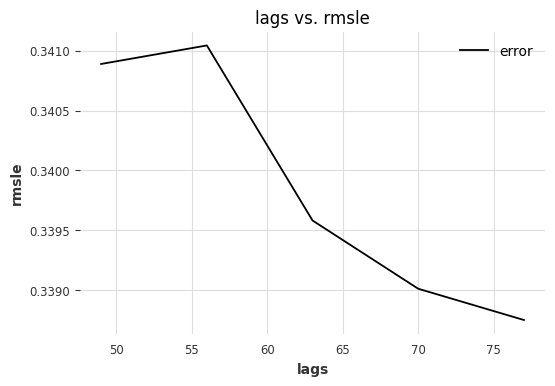

Mean RMSLE for the 33 different product families with lag 77, from best to worst:


BOOKS  :  0.05650918320333895
PRODUCE  :  0.1384069541932304
DAIRY  :  0.1404009904549169
GROCERY I  :  0.15295766061106486
BREAD/BAKERY  :  0.17030662513375053
DELI  :  0.17634061345547758
MEATS  :  0.19422470067528158
PERSONAL CARE  :  0.19528501115657818
BABY CARE  :  0.2066677539436308
HOME CARE  :  0.2087282512213868
POULTRY  :  0.20881361000218632
BEVERAGES  :  0.21907816175823183
EGGS  :  0.25695286662942546
PREPARED FOODS  :  0.2586440748911335
FROZEN FOODS  :  0.26208373017773023
HOME APPLIANCES  :  0.28503446853787384
CLEANING  :  0.3118555130250396
LAWN AND GARDEN  :  0.3535539558754906
LIQUOR,WINE,BEER  :  0.4197912238546465
HOME AND KITCHEN II  :  0.42998499596373385
LADIESWEAR  :  0.4361131132955092
PLAYERS AND ELECTRONICS  :  0.4427811413191351
PET SUPPLIES  :  0.45362139849313377
BEAUTY  :  0.4605576532812884
SEAFOOD  :  0.46126617896864797
HOME AND KITCHEN I  :  0.48601478727346614
AUTO

In [25]:

# Try different lags

lags_list = [49, 56, 63, 70, 77]
LGBM_rmsle_list = []
family_forecast_rmsle_LGBM_list = []
LGBM_Forecasts_Families_back = {}
for lag in tqdm(lags_list):
  for family in tqdm(family_list):
    LGBM_Forecasts_Families_back[family] = pred(family, lag, p=1)
  family_forecast_rmsle_LGBM_list.append(compute_rmsle_per_family(LGBM_Forecasts_Families_back))
  LGBM_rmsle_list.append(compute_rmsle(LGBM_Forecasts_Families_back))

idx = LGBM_rmsle_list.index(min(LGBM_rmsle_list))
print("\n")
print("The lag {:d} caused minimum mean RMSLE for the 33 LightGBM Global Product \
Family Models over all 1782 series is {:.5f}.".format(lags_list[idx],LGBM_rmsle_list[idx]))
print("\n")

x = lags_list
y = LGBM_rmsle_list

plt.figure(dpi=100)
plt.title("lags vs. rmsle")
plt.xlabel("lags")
plt.ylabel("rmsle")
plt.plot(x, y, label="error")
plt.savefig('lags.png')
plt.legend()
plt.show()

print(f"Mean RMSLE for the 33 different product families with lag {lags_list[idx]}, from best to worst:")
print("\n")

for key, value in family_forecast_rmsle_LGBM_list[idx].items():
    print(key, ' : ', value)
  


2.2.2 Different lags_future_covariates

In [52]:
# Try different lags_future

lags_future_covariates_list = [(7,1), (14,1), (21,1)]

LGBM_rmsle_list = []
family_forecast_rmsle_LGBM_list = []
LGBM_Forecasts_Families_back = {}
for f in tqdm(lags_future_covariates_list):
  for family in tqdm(family_list):
    LGBM_Forecasts_Families_back[family] = pred(family, lags_future_covariates=f, p=1)
  family_forecast_rmsle_LGBM_list.append(compute_rmsle_per_family(LGBM_Forecasts_Families_back))
  LGBM_rmsle_list.append(compute_rmsle(LGBM_Forecasts_Families_back))

idx = LGBM_rmsle_list.index(min(LGBM_rmsle_list))
print("\n")
print(f"The lag {lags_future_covariates_list[idx]} caused minimum mean RMSLE for the 33 LightGBM Global Product \
Family Models over all 1782 series is {LGBM_rmsle_list[idx]:5f}.")
print("\n")

# x = lags_future_covariates_list
x = np.arange(7, 22, 7)
y = LGBM_rmsle_list

plt.figure(dpi=100)
plt.title("lags_future_covariates vs. rmsle")
plt.xlabel("lags_future_covariates")
plt.ylabel("rmsle")
plt.plot(x, y, label="error")
plt.savefig('lags_future.png')
plt.legend()
plt.show()

print(f"Mean RMSLE for the 33 different product families with lag {lags_future_covariates_list[idx]}, from best to worst:")
print("\n")

for key, value in family_forecast_rmsle_LGBM_list[idx].items():
    print(key, ' : ', value)


  0%|          | 0/3 [00:12<?, ?it/s]


KeyboardInterrupt: ignored

2.2.3 Different lags_past_covariates

100%|██████████| 3/3 [56:48<00:00, 1136.08s/it]




The lag [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29, -30, -31, -32, -33, -34, -35, -36] caused minimum mean RMSLE for the 33 LightGBM Global Product Family Models over all 1782 series is 0.335423.




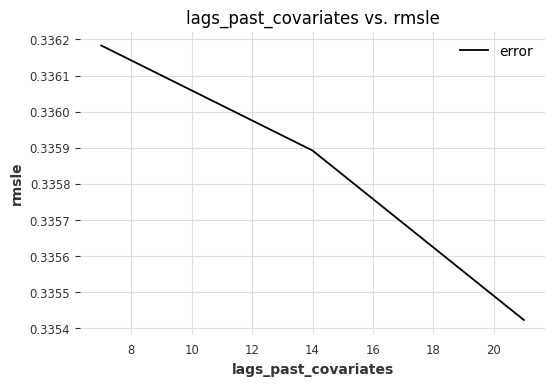

Mean RMSLE for the 33 different product families with lag [-16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29, -30, -31, -32, -33, -34, -35, -36], from best to worst:


BOOKS  :  0.054072497409752
DAIRY  :  0.13981662187316712
PRODUCE  :  0.14185678640600768
GROCERY I  :  0.1513081074267367
BREAD/BAKERY  :  0.16440012082160274
DELI  :  0.1754094187504787
PERSONAL CARE  :  0.19776655781399397
BABY CARE  :  0.2003061224545497
MEATS  :  0.20101774324662275
POULTRY  :  0.20677927459828227
HOME CARE  :  0.2100035215300334
BEVERAGES  :  0.22164430011830222
EGGS  :  0.25632419620178704
PREPARED FOODS  :  0.2591060247232274
FROZEN FOODS  :  0.2652040602930398
HOME APPLIANCES  :  0.27374626265667
CLEANING  :  0.3003762594454314
LAWN AND GARDEN  :  0.34655813322944307
LIQUOR,WINE,BEER  :  0.41294940582835266
LADIESWEAR  :  0.42634118566091767
HOME AND KITCHEN II  :  0.4263418205115276
PLAYERS AND ELECTRONICS  :  0.44164548706522727
PET SUPPLIES  :  0.44601565032221135
SEAFOOD  

In [ ]:

# Try different lags_past

lags_past_covariates_list = [[i for i in range(-16, -23, -1)],
                            [i for i in range(-16, -30, -1)],
                            [i for i in range(-16, -37, -1)]]

LGBM_rmsle_list = []
family_forecast_rmsle_LGBM_list = []
LGBM_Forecasts_Families_back = {}
for p in tqdm(lags_past_covariates_list):
  for family in tqdm(family_list):
    LGBM_Forecasts_Families_back[family] = pred(family, lags_past_covariates=p, p=1)
  family_forecast_rmsle_LGBM_list.append(compute_rmsle_per_family(LGBM_Forecasts_Families_back))
  LGBM_rmsle_list.append(compute_rmsle(LGBM_Forecasts_Families_back))

idx = LGBM_rmsle_list.index(min(LGBM_rmsle_list))
print("\n")
print(f"The lag {lags_past_covariates_list[idx]} caused minimum mean RMSLE for the 33 LightGBM Global Product \
Family Models over all 1782 series is {LGBM_rmsle_list[idx]:5f}.")
print("\n")

# x = lags_past_covariates_list
x = np.arange(7, 22, 7)
y = LGBM_rmsle_list

plt.figure(dpi=100)
plt.title("lags_past_covariates vs. rmsle")
plt.xlabel("lags_past_covariates")
plt.ylabel("rmsle")
plt.plot(x, y, label="error")
plt.legend()
plt.savefig('lags_past.png')
plt.show()

print(f"Mean RMSLE for the 33 different product families with lag {lags_past_covariates_list[idx]}, from best to worst:")
print("\n")

for key, value in family_forecast_rmsle_LGBM_list[idx].items():
    print(key, ' : ', value)

2.2.4 Validation Error for manually-tuned best parameters model

In [27]:
LGBM_Forecasts_Families_back = {}

for family in tqdm(family_list):
   LGBM_Forecasts_Families_back[family] = pred(family,p=2)
  
forecast_list_LGBM = []

for family in family_list:
  forecast_list_LGBM.append(LGBM_Forecasts_Families_back[family])

sales_data = []

for family in family_list:
  sales_data.append(family_TS_dict[family])

def flatten(l):
  return [item for sublist in l for item in sublist]

actual_list = flatten(sales_data)
pred_list_LGBM = flatten(forecast_list_LGBM)

# Mean RMSLE

LGBM_rmsle = rmsle(actual_series = actual_list,
                 pred_series = pred_list_LGBM,
                 n_jobs = -1,
                 inter_reduction=np.mean)

print("\n")
print("The mean RMSLE for the 33 LightGBM Global Product Family Models over all 1782 series is {:.5f}.".format(LGBM_rmsle))
print("\n")

# Mean RMSLE for Families

family_forecast_rmsle_LGBM = {}

for family in family_list:

  LGBM_rmsle_family = rmsle(actual_series = family_TS_dict[family],
                 pred_series = LGBM_Forecasts_Families_back[family],
                 n_jobs = -1,
                 inter_reduction=np.mean)
  
  family_forecast_rmsle_LGBM[family] = LGBM_rmsle_family

family_forecast_rmsle_LGBM = dict(sorted(family_forecast_rmsle_LGBM.items(), key=lambda item: item[1]))

print("Mean RMSLE for the 33 different product families, from best to worst:")
print("\n")

# Iterate over key/value pairs in dict and print them
for key, value in family_forecast_rmsle_LGBM.items():
    print(key, ' : ', value)

100%|██████████| 33/33 [15:44<00:00, 28.64s/it]




The mean RMSLE for the 33 LightGBM Global Product Family Models over all 1782 series is 0.33958.


Mean RMSLE for the 33 different product families, from best to worst:


BOOKS  :  0.055938673190441046
DAIRY  :  0.14028820187937316
PRODUCE  :  0.14325756541690748
GROCERY I  :  0.14932563987971417
BREAD/BAKERY  :  0.1654753341955706
DELI  :  0.1801947390209564
MEATS  :  0.1966424437734679
PERSONAL CARE  :  0.20447472761537114
HOME CARE  :  0.20664549835852897
BABY CARE  :  0.2074402464157929
POULTRY  :  0.20749941819160925
BEVERAGES  :  0.21950511313079596
EGGS  :  0.25926484857234827
PREPARED FOODS  :  0.260207988765711
FROZEN FOODS  :  0.2624665192330445
HOME APPLIANCES  :  0.2924003703029079
CLEANING  :  0.2956193399273955
LAWN AND GARDEN  :  0.3626902283282827
LIQUOR,WINE,BEER  :  0.4196799408952217
HOME AND KITCHEN II  :  0.4302846582813662
LADIESWEAR  :  0.43100593083986766
PLAYERS AND ELECTRONICS  :  0.4429854959762384
SEAFOOD  :  0.457799731298384
PET SUPPLIES  :  0.4580405439

3. Train Global LightGDM Model with Full Training Data

After getting the optimal hyperparameters, we train the model with all training data. The model will then be used for forecasting.

3.1 Train with models whose hyperparameters are got from Optuna

(Skip to next part if you don't want models from Optuna)

In [22]:
# Train 33 Global LightGBM Models with Full Data from Optuna

LGBM_Models_Submission = {}

for family in tqdm(family_list):

  # Define Data for family
  sales_family = family_TS_transformed_dict[family]
  training_data = [ts for ts in sales_family] 
  TCN_covariates = future_covariates_dict[family]
  train_sliced = [training_data[i].slice_intersect(TCN_covariates[i]) for i in range(0,len(training_data))]
  
  # for model with Optuna generated hyperparameters

  LGBM_Model_Submission = LGBM_dict[family]
     
  LGBM_Model_Submission.fit(series=train_sliced, 
                        future_covariates=TCN_covariates,
                        past_covariates=transactions_transformed,
                        # past_covariates=past_covariates_dict[family],
                        # past_covariates=only_past_covariates_dict[family],
                        verbose=True)

  LGBM_Models_Submission[family] = LGBM_Model_Submission

100%|██████████| 33/33 [12:02<00:00, 21.88s/it]


3.2 Train with models of hardcoded best hyperparameters from manual tuning

(Skip this part if you want generate results from Optuna-tuned models, otherwise it will overwrite)

In [50]:

# Train 33 Global LightGBM Models with Full Data

LGBM_Models_Submission = {}

for family in tqdm(family_list):

  # Define Data for family
  sales_family = family_TS_transformed_dict[family]
  training_data = [ts for ts in sales_family] 
  TCN_covariates = future_covariates_dict[family]
  train_sliced = [training_data[i].slice_intersect(TCN_covariates[i]) for i in range(0,len(training_data))]

  # sharing parameters, set manually
  
  LGBM_Model_Submission = LightGBMModel(lags = 63,
                             lags_future_covariates = (14,1),
                             lags_past_covariates = [ i for i in range(-16, -30, -1)],
                             output_chunk_length=1,
                             random_state=2022,
                            #  max_bin= [63],
                             gpu_use_dp= "false")
     
  LGBM_Model_Submission.fit(series=train_sliced, 
                        future_covariates=TCN_covariates,
                        past_covariates=transactions_transformed,
                        # past_covariates=past_covariates_dict[family],
                        # past_covariates=only_past_covariates_dict[family],
                        verbose=True)

  LGBM_Models_Submission[family] = LGBM_Model_Submission

100%|██████████| 33/33 [15:05<00:00, 27.45s/it]


4. Forecast Test Data for Submission

Forecast the test data and format the predictions into a submission.csv file for Kaggle competition.

In [51]:
# Generate Forecasts for Submission

LGBM_Forecasts_Families_Submission = {}

for family in tqdm(family_list):

  sales_family = family_TS_transformed_dict[family]
  training_data = [ts for ts in sales_family]
  LGBM_covariates = future_covariates_dict[family]
  train_sliced = [training_data[i].slice_intersect(TCN_covariates[i]) for i in range(0,len(training_data))]

  forecast_LGBM = LGBM_Models_Submission[family].predict(n=16,
                                         series=train_sliced,
                                         future_covariates=LGBM_covariates,
                                         past_covariates=transactions_transformed)
                                        # past_covariates=past_covariates_dict[family]
                                        # past_covariates=only_past_covariates_dict[family])
  
  LGBM_Forecasts_Families_Submission[family] = forecast_LGBM

# Transform Back

LGBM_Forecasts_Families_back_Submission = {}

for family in tqdm(family_list):

  LGBM_Forecasts_Families_back_Submission[family] = family_pipeline_dict[family].inverse_transform(LGBM_Forecasts_Families_Submission[family], partial=True)

# Zero Forecasting

for family in tqdm(LGBM_Forecasts_Families_back_Submission):
  for n in range(0,len(LGBM_Forecasts_Families_back_Submission[family])):
    if (family_TS_dict[family][n].univariate_values()[-21:] == 0).all():
        LGBM_Forecasts_Families_back_Submission[family][n] = LGBM_Forecasts_Families_back_Submission[family][n].map(lambda x: x * 0)
        
# Prepare Submission in Correct Format

listofseries = []

for store in range(0,54):
  for family in tqdm(family_list):
      oneforecast = LGBM_Forecasts_Families_back_Submission[family][store].pd_dataframe()
      oneforecast.columns = ['fcast']
      listofseries.append(oneforecast)

df_forecasts = pd.concat(listofseries) 
df_forecasts.reset_index(drop=True, inplace=True)

# No Negative Forecasts
df_forecasts[df_forecasts < 0] = 0
forecasts_kaggle = pd.concat([df_test_sorted, df_forecasts.set_index(df_test_sorted.index)], axis=1)
forecasts_kaggle_sorted = forecasts_kaggle.sort_values(by=['id'])
forecasts_kaggle_sorted = forecasts_kaggle_sorted.drop(['date','store_nbr','family'], axis=1)
forecasts_kaggle_sorted = forecasts_kaggle_sorted.rename(columns={"fcast": "sales"})
forecasts_kaggle_sorted = forecasts_kaggle_sorted.reset_index(drop=True)

# Submission
submission_kaggle = forecasts_kaggle_sorted
submission_kaggle.to_csv('/content/drive/My Drive/Colab Notebooks/submission.csv', index=False)

100%|██████████| 33/33 [00:00<00:00, 1029.61it/s]
